# Binary catch

**При каких условиях два тела, налетающие друг на друга с бесконечности (в системе центра масс) станут связной системой из-за испускания гравволн?**

In [1]:
(* https://mathematica.stackexchange.com/questions/850/how-do-i-clear-all-user-defined-symbols/861#861 *)
<< Utilities`CleanSlate`
CleanSlate[];

ClearAll["Global`*"]
(* ClearSystemCache[] *)
(* https://mathematica.stackexchange.com/questions/111605/quit-vs-clearallglobal *)
if[Length[Names["Global`*"]] > 0, Remove["Global`*"]];

(* PacletInstall[
    "TensorSimplify",

    "Site" -> "http://raw.githubusercontent.com/carlwoll/TensorSimplify/master"
]; *)
<<TensorSimplify`

  (CleanSlate) Contexts purged: {Global`}
  (CleanSlate) Approximate kernel memory recovered: 1 Kb


## Einstein Summation

In [10]:
ClearAll@EinsteinSummation

EinsteinSummation[in_List, arrays_] := Module[
  {res =
    isum[in -> Cases[Tally @ Flatten @ in, {_, 1}][[All, 1]], arrays]},
  res /; res =!= $Failed
  ]

EinsteinSummation[in_List -> out_, arrays_] := Module[
  {res = isum[in -> out, arrays]},
  res /; res =!= $Failed
  ]

isum[in_List -> out_, arrays_List] := Catch@Module[
  {indices, contracted, uncontracted, contractions, transpose},
  If[Length[in] != Length[arrays],
    Message[EinsteinSummation::length, Length[in], Length[arrays]];
    Throw[$Failed]];
  MapThread[
    If[IntegerQ@TensorRank[#1] && Length[#1] != TensorRank[#2],
      Message[EinsteinSummation::shape, #1, #2];
      Throw[$Failed]] &, {in, arrays}];
  indices = Tally[Flatten[in, 1]];
  If[DeleteCases[indices, {_, 1 | 2}] =!= {},
    Message[EinsteinSummation::repeat,
      Cases[indices, {x_, Except[1 | 2]} :> x]];
    Throw[$Failed]];
  uncontracted = Cases[indices, {x_, 1} :> x];
  If[Sort[uncontracted] =!= Sort[out],
    Message[EinsteinSummation::output, uncontracted, out];
    Throw[$Failed]];
  contracted = Cases[indices, {x_, 2} :> x];
  contractions = Flatten[Position[Flatten[in, 1], #]] & /@ contracted;
  transpose = FindPermutation[uncontracted, out];
  Activate@
    TensorTranspose[
      TensorContract[Inactive[TensorProduct] @@ arrays, contractions],
    transpose]]

EinsteinSummation::length =
  "Number of index specifications (`1`) does not match the number of \
tensors (`2`)";
EinsteinSummation::shape =
  "Index specification `1` does not match the tensor rank of `2`";
EinsteinSummation::repeat =
  "Index specifications `1` are repeated more than twice";
EinsteinSummation::output =
  "The uncontracted indices don't match the desired output";

In [18]:
(* Правила для скрытия аргументов в TraditionalForm *)

Unprotect[Subscript, OverHat, Derivative];

MakeBoxes[OverHat[r_][OverHat[t]], TraditionalForm] :=
  MakeBoxes[OverHat[r], TraditionalForm]

MakeBoxes[\[Phi][OverHat[t]], TraditionalForm] :=
  MakeBoxes[\[Phi], TraditionalForm]

MakeBoxes[Subscript[OverHat[r], n_][OverHat[t]], TraditionalForm] :=
  SubscriptBox[OverscriptBox["r", "^"], ToString[n]];

MakeBoxes[OverHat[\[Omega]][OverHat[t]], TraditionalForm] :=
  OverscriptBox["\[Omega]", "^"];

MakeBoxes[Derivative[n_][f_][OverHat[t]], TraditionalForm] := Module[{primes},
  primes = StringJoin[Table["\[Prime]", n]];
  SuperscriptBox[ToBoxes[f], primes]
];

Protect[Subscript, OverHat, Derivative];

$\hat{r}_k$

FormBox[TagBox[RowBox[{"(", "⁠", 

 
>         TagBox[GridBox[{{RowBox[{OverscriptBox["r", "^"], " ", 

 
>               RowBox[{"cos", "(", "ϕ", ")"}]}]}, 

 
>            {RowBox[{OverscriptBox["r", "^"], " ", RowBox[{"sin", "(", "ϕ", ")"}]}]}}, 

 
>           Rule[RowSpacings, 1], Rule[ColumnAlignments, Center], 

 
>           Rule[ColumnAlignments, Left]], Column], "⁠", ")"}], 

 
>       Function[BoxForm`e$, MatrixForm[BoxForm`e$]]], TraditionalForm]
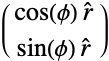

In [27]:
rh = {OverHat[r][OverHat[t]]*Cos[\[Phi][OverHat[t]]], OverHat[r][OverHat[t]]*Sin[\[Phi][OverHat[t]]]};
rh // MatrixForm // TraditionalForm

In [28]:
$Assumptions = {
  {OverHat[r][OverHat[t]], Subscript[OverHat[r],2][OverHat[t]], OverHat[t], u} \[Element] PositiveReals
};
$Assumptions = Join[$Assumptions, {rh \[Element] NonNegativeReals}];

## Система движения в декартовых координатах
$$
\frac{d^2r_k}{dt^2} = -\frac{G(m_A+m_B)}{r^3}r_k - \frac{2}{5}f_{ki}^{(5)}r_i
$$

Ч.Мизнер, К.Торн, Дж.Уилер Гравтация, Т.3, §36.8, стр. 222

Введём обозначения для полной и приведённой масс
$$
M=m_A+m_B; \quad
\mu = m_{AB} = \frac{m_A m_B}{M}
$$
Задача двух самогравитирующих тел с массами $m_A$ и $m_B$
в системе отсчёта центра масс всегда сводится
к задаче движения тела массы $\mu$
в центральном поле массы $M$.

$f_{ki}$ - квадрупольный момент системы.
Задача решается методом последовательных приближений
Первоначально строится решение в приближении Ньютона,
затем для полученной конфигурации находится квадрупольный момент
и находится его пятая производная по времени.
Уже на следубщем шаге (уравнение выше)
находятся решение с **заданной** функций от времени (**и только времени**) $f_{ki}^{(5)}$.

### Безразмерные единицы
$$
\begin{align}
r &= b\hat{r} \\
t &= t_0\hat{t} \\
f_{ij} &= b^2\frac{G}{c^5}\mu\hat{f}_{ij} \\
f_{ij}^{(5)} &= \frac{b^2}{t_0^5}\frac{G}{c^5}\mu\hat{f}_{ij}^{(5)}
\end{align}
$$

$\hat{f}_{ki}$

FormBox[TagBox[RowBox[{"(", "⁠", 

 
>         GridBox[{{RowBox[{FractionBox["1", "6"], " ", 

 
>              SuperscriptBox[OverscriptBox["r", "^"], "2"], " ", 

 
>              RowBox[{"(", RowBox[{RowBox[{"3", " ", 

 
>                    RowBox[{"cos", "(", RowBox[{"2", " ", "ϕ"}], ")"}]}], "+",\
 
>    "1"}]\
, ")"}]}], RowBox[{SuperscriptBox[OverscriptBox["r", "^"], "2"], " ", 

 
>              RowBox[{"sin", "(", "ϕ", ")"}], " ", RowBox[{"cos", "(", "ϕ", ")"}]}]}, 

 
>           {RowBox[{SuperscriptBox[OverscriptBox["r", "^"], "2"], " ", 

 
>              RowBox[{"sin", "(", "ϕ", ")"}], " ", RowBox[{"cos", "(", "ϕ", ")"}]}], 

 
>            RowBox[{FractionBox["1", "3"], " ", 

 
>              SuperscriptBox[OverscriptBox["r", "^"], "2"], " ", 

 
>              RowBox[{"(", RowBox[{RowBox[{"3", " ", 

 
>                    RowBox[{SuperscriptBox["sin", "2"], "(", "ϕ", ")"}]}], "-", "1"}], 

 
>                ")"}]}]}}, Rule[RowSpacings, 1], Rule[ColumnSpacings, 1], 

 
>          Rule[RowAlignments, Baseline], Rule[ColumnAlignments, Center]], "⁠", ")"}], 

 
>       Function[BoxForm`e$, MatrixForm[BoxForm`e$]]], TraditionalForm]
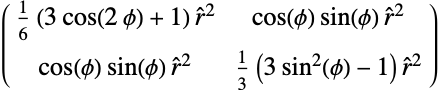

In [31]:
fh = Simplify[Array[rh[[#]]*rh[[#2]] - 1/3*KroneckerDelta[#, #2]*(OverHat[r][OverHat[t]])^2 &, {2, 2}], Trig -> True];
fh // MatrixForm // TraditionalForm

<span style="color:brown">**NB:**</span> Здесь и далее мы не записываем компоненты квадрупольного момента для $z$, так как они сворачиваются с нулевыми $r_z$.

Однако нужно запомнить, что след полного квадрупольного момента и его пятой производной **нулевой**!

$\hat{f}_{ki}^{(5)}$ - заданная функция (см. выше)

FormBox[TagBox[RowBox[{"(", "⁠", 

 
>         GridBox[{{TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>               RowBox[List["x", ",", "x"]]], "\"(5)\""], "Superscript", 

 
>             Rule[SyntaxForm, SuperscriptBox]], 

 
>            TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>               RowBox[List["x", ",", "y"]]], "\"(5)\""], "Superscript", 

 
>             Rule[SyntaxForm, SuperscriptBox]]}, 

 
>           {TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>               RowBox[List["x", ",", "y"]]], "\"(5)\""], "Superscript", 

 
>             Rule[SyntaxForm, SuperscriptBox]], 

 
>            TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>               RowBox[List["y", ",", "y"]]], "\"(5)\""], "Superscript", 

 
>             Rule[SyntaxForm, SuperscriptBox]]}}, Rule[RowSpacings, 1], 

 
>          Rule[ColumnSpacings, 1], Rule[RowAlignments, Baseline], 

 
>          Rule[ColumnAlignments, Center]], "⁠", ")"}], 

 
>       Function[BoxForm`e$, MatrixForm[BoxForm`e$]]], TraditionalForm]
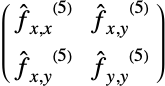

In [35]:
(* fh5 = Array[Superscript[Subscript[OverHat[f], {x, y}[[#1]], {x, y}[[#2]]], "(5)"] &, {2, 2}] *)
(* Symmetric version *)
fh5 = Array[If[#1 <= #2,
                    Superscript[Subscript[OverHat[f], {x, y}[[#1]], {x, y}[[#2]]], "(5)"],
                    Superscript[Subscript[OverHat[f], {x, y}[[#2]], {x, y}[[#1]]], "(5)"]] &, {2, 2}];
fh5 // MatrixForm // TraditionalForm

$\hat{f}_{ki}^{(5)}\hat{r}_i$

FormBox[TagBox[RowBox[{"(", "⁠", 

 
>         TagBox[GridBox[{{RowBox[{RowBox[{OverscriptBox["r", "^"], " ", 

 
>                 RowBox[{"sin", "(", "ϕ", ")"}], " ", 

 
>                 TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>                    RowBox[List["x", ",", "y"]]], "\"(5)\""], "Superscript", 

 
>                  Rule[SyntaxForm, SuperscriptBox]]}], "+", 

 
>               RowBox[{OverscriptBox["r", "^"], " ", RowBox[{"cos", "(", "ϕ", ")"}], 

 
>                 " ", TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>                    RowBox[List["x", ",", "x"]]], "\"(5)\""], "Superscript", 

 
>                  Rule[SyntaxForm, SuperscriptBox]]}]}]}, 

 
>            {RowBox[{RowBox[{OverscriptBox["r", "^"], " ", 

 
>                 RowBox[{"cos", "(", "ϕ", ")"}], " ", 

 
>                 TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>                    RowBox[List["x", ",", "y"]]], "\"(5)\""], "Superscript", 

 
>                  Rule[SyntaxForm, SuperscriptBox]]}], "+", 

 
>               RowBox[{OverscriptBox["r", "^"], " ", RowBox[{"sin", "(", "ϕ", ")"}], 

 
>                 " ", TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>                    RowBox[List["y", ",", "y"]]], "\"(5)\""], "Superscript", 

 
>                  Rule[SyntaxForm, SuperscriptBox]]}]}]}}, Rule[RowSpacings, 1], 

 
>           Rule[ColumnAlignments, Center], Rule[ColumnAlignments, Left]], Column], "⁠",\
 
>    
      ")"}], Function[BoxForm`e$, MatrixForm[BoxForm`e$]]], TraditionalForm]
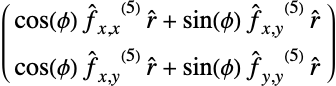

In [37]:
fh5rh = EinsteinSummation[{{k, i}, {i}}, {fh5, rh}];
fh5rh // MatrixForm // TraditionalForm

Система движения в безразмерной записи будет выглядеть как

$$
\frac{d^2\hat{r}_k}{d\hat{t}^2} = -\frac{t_0^2}{b^3}\frac{GM}{\hat{r}^3}\hat{r}_k - \frac{2}{5}\frac{b^2}{t_0^3}\frac{G}{c^5}\mu\hat{f}_{ki}^{(5)}\hat{r}_i
$$

Пусть $t_0 = \sqrt{\frac{b^3}{GM}}$, а $b$ - прицельное расстояние, тогда система движения перепишется как

$$
\frac{d^2\hat{r}_k}{d\hat{t}^2} + \frac{\hat{r}_k}{\hat{r}^3} = - \epsilon_G\hat{f}_{ki}^{(5)}\hat{r}_i\quad,
$$
или
$$
\hat{r}_k^{(2)} + \frac{\hat{r}_k}{\hat{r}^3} = - \epsilon_G\hat{f}_{ki}^{(5)}\hat{r}_i\quad,
$$

где безразмерная постоянная
$\epsilon_G =
  \frac{2}{5}\frac{b^2}{t_0^3}\frac{G}{c^5}\mu
  = \frac{2}{5}\frac{\mu}{M} \left( \frac{GM}{bc^2} \right)^{\frac{5}{2}}
  = \frac{2}{5}\frac{\mu}{M} \left( \frac{r_s}{2b} \right)^{\frac{5}{2}}$.

Здесь $r_s = \frac{2 G M}{c^2}$ - сумма радиусов Шварцшильда двух тел.
Заметим, что $f_{ij}^{(5)} = \frac{5}{2}\frac{\epsilon_G}{t_0^2}\hat{f}_{ij}^{(5)}$

Можно еще записать, что
$\epsilon_G
  = \frac{2}{5}\frac{q}{(1 + q)^2} \left( \frac{r_s}{2b} \right)^{\frac{5}{2}}$,
где $q = \frac{m_1}{m_2}$ - отношение меньшей массы тела к большей, $m_1 < m_2$.
Откуда можно видеть, что $\epsilon_G \ll 1$, когда $q \ll 1$ или/и $r_s \ll b$.

<span style="color:red">**TODO_1:**</span> Обязательное ли условие $\epsilon_G \ll 1$?

## Переход к полярным координатам от декартовых
Повернём систему с помощью матрицы вращения $R_{ij}(\phi)$ на угол $\phi$ по **часовой** стрелке

FormBox[TagBox[RowBox[{"(", "⁠", 

 
>         GridBox[{{RowBox[{"cos", "(", "ϕ", ")"}], RowBox[{"sin", "(", "ϕ", ")"}]}, 

 
>           {RowBox[{"-", RowBox[{"sin", "(", "ϕ", ")"}]}], 

 
>            RowBox[{"cos", "(", "ϕ", ")"}]}}, Rule[RowSpacings, 1], 

 
>          Rule[ColumnSpacings, 1], Rule[RowAlignments, Baseline], 

 
>          Rule[ColumnAlignments, Center]], "⁠", ")"}], 

 
>       Function[BoxForm`e$, MatrixForm[BoxForm`e$]]], TraditionalForm]
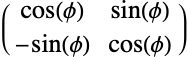

In [38]:
RotationMatrix[-\[Phi]] // MatrixForm // TraditionalForm

#### LHS системы после поворота

FormBox[TagBox[RowBox[{"(", "⁠", 
      TagBox[GridBox[{{RowBox[{RowBox[{"-", 

 
>                 RowBox[{"2", " ", SuperscriptBox[OverscriptBox["r", "^"], "′"], 

 
>                   " ", SuperscriptBox["ϕ", "′"], " ", 

 
>                   RowBox[{"sin", "(", "ϕ", ")"}]}]}], "+", 

 
>               RowBox[{OverscriptBox["r", "^"], " ", 

 
>                 RowBox[{"(", RowBox[{RowBox[{SuperscriptBox[RowBox[

 
>                         {"(", SuperscriptBox["ϕ", "′"], ")"}], "2"], " ", 

 
>                       RowBox[{"(", 

 
>                         RowBox[{"-", RowBox[{"cos", "(", "ϕ", ")"}]}], ")"}]}], 

 
>                     "-", RowBox[{SuperscriptBox["ϕ", "′′"], " ", 

 
>                       RowBox[{"sin", "(", "ϕ", ")"}]}]}], ")"}]}], "+", 

 
>               RowBox[{SuperscriptBox[OverscriptBox["r", "^"], "′′"], " ", 

 
>                 RowBox[{"cos", "(", "ϕ", ")"}]}], "+", 

 
>               FractionBox[RowBox[{"cos", "(", "ϕ", ")"}], 

 
>                SuperscriptBox[OverscriptBox["r", "^"], "2"]]}]}, 

 
>            {RowBox[{RowBox[{"2", " ", SuperscriptBox[OverscriptBox["r", "^"], "′"], 

 
>                 " ", SuperscriptBox["ϕ", "′"], " ", RowBox[{"cos", "(", "ϕ",\
 
>    ")"}]}]\
, "+", RowBox[{OverscriptBox["r", "^"], " ", 

 
>                 RowBox[{"(", RowBox[{RowBox[{SuperscriptBox["ϕ", "′′"], " ", 

 
>                       RowBox[{"cos", "(", "ϕ", ")"}]}], "-", 

 
>                     RowBox[{SuperscriptBox[RowBox[{"(", 

 
>                          SuperscriptBox["ϕ", "′"], ")"}], "2"], " ", 

 
>                       RowBox[{"sin", "(", "ϕ", ")"}]}]}], ")"}]}], "+", 

 
>               RowBox[{SuperscriptBox[OverscriptBox["r", "^"], "′′"], " ", 

 
>                 RowBox[{"sin", "(", "ϕ", ")"}]}], "+", 

 
>               FractionBox[RowBox[{"sin", "(", "ϕ", ")"}], 

 
>                SuperscriptBox[OverscriptBox["r", "^"], "2"]]}]}}, 

 
>           Rule[RowSpacings, 1], Rule[ColumnAlignments, Center], 

 
>           Rule[ColumnAlignments, Left]], Column], "⁠", ")"}], 

 
>       Function[BoxForm`e$, MatrixForm[BoxForm`e$]]], TraditionalForm]
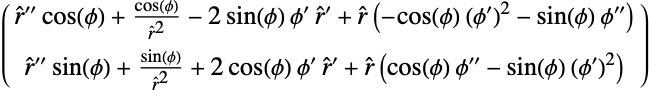

In [40]:
LHSMotion = D[rh, {OverHat[t], 2}] + Simplify[rh / Norm[rh]^3];
LHSMotion // MatrixForm // TraditionalForm

FormBox[TagBox[RowBox[{"(", "⁠", 
      TagBox[GridBox[{{RowBox[{RowBox[{"-", 

 
>                 RowBox[{RowBox[{OverscriptBox["r", "^"]}], " ", 

 
>                   SuperscriptBox[RowBox[{"(", SuperscriptBox["ϕ", "′"], ")"}], 

 
>                    "2"]}]}], "+", SuperscriptBox[OverscriptBox["r", "^"], "′′"], 

 
>               "+", FractionBox["1", SuperscriptBox[OverscriptBox["r", "^"],\
 
>    "2"]]}]}\
, {RowBox[{RowBox[{OverscriptBox["r", "^"], " ", SuperscriptBox["ϕ",\
 
>    "′′"]}], "+", 
            RowBox[{"2", " ", SuperscriptBox[OverscriptBox["r",\
 
>    "^"], "′"], " ", 
              SuperscriptBox["ϕ", "′"]}]}]}}, Rule[RowSpacings,\
 
>    1], 
        Rule[ColumnAlignments, Center], Rule[ColumnAlignments, Left]],\
 
>    Column], "⁠", 
      ")"}], Function[BoxForm`e$, MatrixForm[BoxForm`e$]]],\
 
>    TraditionalForm]
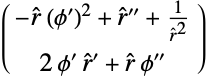

In [41]:
RotatedLHSMotion = Simplify[RotationMatrix[-\[Phi][OverHat[t]]] . LHSMotion, Trig -> True] // MatrixForm // TraditionalForm

Так как $\hat{\omega} \equiv \phi^{(1)}$, то

FormBox[TagBox[RowBox[{"(", "⁠", 

 
>         TagBox[GridBox[{{RowBox[{RowBox[{RowBox[{"-", OverscriptBox["r", "^"]}], 

 
>                 " ", SuperscriptBox[OverscriptBox["ω", "^"], "2"]}], "+", 

 
>               SuperscriptBox[OverscriptBox["r", "^"], "′′"], "+", 

 
>               FractionBox["1", SuperscriptBox[OverscriptBox["r", "^"], "2"]]}]}, 

 
>            {RowBox[{RowBox[{"2", " ", OverscriptBox["ω", "^"], " ", 

 
>                 SuperscriptBox[OverscriptBox["r", "^"], "′"]}], "+", 

 
>               RowBox[{OverscriptBox["r", "^"], " ", 

 
>                 SuperscriptBox[OverscriptBox["ω", "^"], "′"]}]}]}}, 

 
>           Rule[RowSpacings, 1], Rule[ColumnAlignments, Center], 

 
>           Rule[ColumnAlignments, Left]], Column], "⁠", ")"}], 

 
>       Function[BoxForm`e$, MatrixForm[BoxForm`e$]]], TraditionalForm]
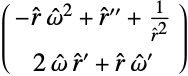

In [43]:
OmegaReplace = Derivative[n_][\[Phi]][OverHat[t]] :> Derivative[n-1][OverHat[\[Omega]]][OverHat[t]];

OmegaLHSMotion = RotatedLHSMotion /. OmegaReplace // TraditionalForm

### RHS системы после поворота

FormBox[TagBox[RowBox[{"(", "⁠", 

 
>         TagBox[GridBox[{{RowBox[{OverscriptBox["r", "^"], " ", 

 
>               RowBox[{"(", RowBox[{"-", SubscriptBox["ϵ", "G"]}], ")"}], " ", 

 
>               RowBox[{"(", RowBox[{RowBox[{RowBox[{"sin", "(", 

 
>                       RowBox[{"2", " ", "ϕ"}], ")"}], " ", 

 
>                     TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>                        RowBox[List["x", ",", "y"]]], "\"(5)\""], "Superscript", 

 
>                      Rule[SyntaxForm, SuperscriptBox]]}], "+", 

 
>                   RowBox[{RowBox[{SuperscriptBox["cos", "2"], "(", "ϕ", ")"}], 

 
>                     " ", TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>                        RowBox[List["x", ",", "x"]]], "\"(5)\""], "Superscript", 

 
>                      Rule[SyntaxForm, SuperscriptBox]]}], "+", 

 
>                   RowBox[{RowBox[{SuperscriptBox["sin", "2"], "(", "ϕ", ")"}], 

 
>                     " ", TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>                        RowBox[List["y", ",", "y"]]], "\"(5)\""], "Superscript", 

 
>                      Rule[SyntaxForm, SuperscriptBox]]}]}], ")"}]}]}, 

 
>            {RowBox[{RowBox[{"-", FractionBox["1", "2"]}], " ", 

 
>               OverscriptBox["r", "^"], " ", SubscriptBox["ϵ", "G"], " ", 

 
>               RowBox[{"(", RowBox[{RowBox[{RowBox[{"sin", "(", 

 
>                       RowBox[{"2", " ", "ϕ"}], ")"}], " ", 

 
>                     RowBox[{"(", RowBox[{TemplateBox[List[SubscriptBox[

 
>                            OverscriptBox["f", "^"], 

 
>                            RowBox[List["y", ",", "y"]]], "\"(5)\""], 

 
>                          "Superscript", Rule[SyntaxForm, SuperscriptBox]], "-", 

 
>                         TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>                            RowBox[List["x", ",", "x"]]], "\"(5)\""], 

 
>                          "Superscript", Rule[SyntaxForm, SuperscriptBox]]}], ")"}]}\

 
>   ], "+", RowBox[{"2", " ", RowBox[{"cos", "(", RowBox[{"2", " ", "ϕ"}], ")"}], 

 
>                     " ", TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>                        RowBox[List["x", ",", "y"]]], "\"(5)\""], "Superscript", 

 
>                      Rule[SyntaxForm, SuperscriptBox]]}]}], ")"}]}]}}, 

 
>           Rule[RowSpacings, 1], Rule[ColumnAlignments, Center], 

 
>           Rule[ColumnAlignments, Left]], Column], "⁠", ")"}], 

 
>       Function[BoxForm`e$, MatrixForm[BoxForm`e$]]], TraditionalForm]
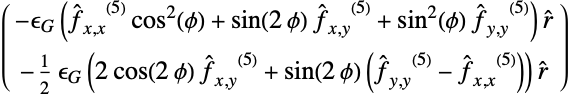

In [45]:
RHSMotion = -Subscript[\[Epsilon], G] FullSimplify[RotationMatrix[-\[Phi][OverHat[t]]] . fh5rh, Trig -> True];
RHSMotion // MatrixForm // TraditionalForm

<span style="color:brown">**NB:**</span> Полученные выражения <span style="color:green">**совпадают**</span> с уравнениями (10) и (9) из файла Binary.pdf

## Получим теперь **энергетическую** систему уравнений

В задача двух тел без учёта гравитационного излучения в системе центра масс в полярных координатах радиус-вектор $\hat{r}_k$ задаётся как:
$$
\hat{r}_k = \hat{r} e_{1k} \quad,
$$
где:
- $\hat{r}$ — расстояние между телами,
- $e_{1k}$ — единичный вектор в направлении $\hat{r}_k$.

Скорость в полярных координатах выражается как:
$$
\hat{r}_k^{(1)} = \hat{r}^{(1)} e_{1k} + \hat{r} \phi^{(1)} e_{2k} \quad,
$$
где:
- $\hat{r}^{(1)}$ — радиальная скорость
- $\hat{\omega} \equiv \phi^{(1)}$ — угловая скорость
- $e_{2k}$ — единичный вектор, перпендикулярный $e_{1k}$.

### **Кинетическая энергия**
Кинетическая энергия $T$ в полярных координатах выражается через радиальную и тангенциальную составляющие скорости:
$$
T = \mu\frac{b^2}{2 t_0^2} (\hat{r}_k^{(1)})^2 = \mu\frac{b^2}{2 t_0^2} \left( (\hat{r}^{(1)})^2 + \hat{r}^2 \hat{\omega}^2 \right) = \frac{G \mu M}{b} \frac{1}{2}\left( (\hat{r}^{(1)})^2 + \hat{r}^2 \hat{\omega}^2 \right)
$$

### **Потенциальная энергия**
Потенциальная энергия $U$ зависит только от расстояния $\hat{r}$:
- Для гравитационного взаимодействия:
  $$
  U = -\frac{G m_A m_B}{b \hat{r}} = -\frac{G \mu M}{b \hat{r}}.
  $$

### **Полная энергия**
Полная энергия $E$ в полярных координатах:
$$
E = T + U = \frac{G \mu M}{b}\left(\frac{(\hat{r}^{(1)})^2}{2} + \frac{\hat{r}^2 \hat{\omega}^2}{2} - \frac{1}{\hat{r}}\right) = \frac{G \mu M}{b} \hat{E}
$$

Здесь $\hat{E}$ - безразмерная энергия:

FormBox[RowBox[{RowBox[{FractionBox["1", "2"], " ", 

 
>          SuperscriptBox[OverscriptBox["r", "^"], "2"], " ", 

 
>          SuperscriptBox[OverscriptBox["ω", "^"], "2"]}], "+", 

 
>        RowBox[{FractionBox["1", "2"], " ", 

 
>          SuperscriptBox[RowBox[{"(", SuperscriptBox[OverscriptBox["r", "^"], "′"], 

 
>             ")"}], "2"]}], "-", FractionBox["1", OverscriptBox["r", "^"]]}], 

 
>      TraditionalForm]
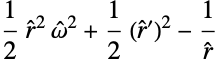

In [47]:
Energy = (D[OverHat[r][OverHat[t]], OverHat[t]])^2/2 + (OverHat[r][OverHat[t]] OverHat[\[Omega]][OverHat[t]])^2/2 - 1/OverHat[r][OverHat[t]];
Energy // TraditionalForm

### **Момента импульса**
Момент импульса $J$ в системе центра масс:
$$
J = \mu\frac{b^2}{t_0} \hat{r}^2 \hat{\omega} = \mu(G M b)^{1/2} \hat{r}^2 \hat{\omega} = \mu(G M b)^{1/2} \hat{J}
$$

Здесь $\hat{J}$ - безразмерный момент импульса:

In [49]:
AngularMomentum = (OverHat[r][OverHat[t]])^2 OverHat[\[Omega]][OverHat[t]];
AngularMomentum // TraditionalForm

FormBox[RowBox[{SuperscriptBox[OverscriptBox["r", "^"], "2"], " ", 

 
>        OverscriptBox["ω", "^"]}], TraditionalForm]

Отсюда $\frac{1}{\hat{r}^{(1)}}\left(\frac{d\hat{E}}{d\hat{t}} - \hat{\omega} \frac{d\hat{J}}{d\hat{t}}\right)$

FormBox[RowBox[{RowBox[{"-", RowBox[{RowBox[{OverscriptBox["r", "^"]}], " ", 

 
>            SuperscriptBox[OverscriptBox["ω", "^"], "2"]}]}], "+", 

 
>        SuperscriptBox[OverscriptBox["r", "^"], "′′"], "+", 

 
>        FractionBox["1", SuperscriptBox[OverscriptBox["r", "^"], "2"]]}],\
 
>    TraditionalForm]
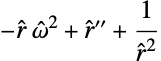

In [50]:
Simplify[(D[Energy, OverHat[t]] - (AngularMomentum/OverHat[r][OverHat[t]]^2)(D[AngularMomentum, OverHat[t]]))/(D[OverHat[r][OverHat[t]], OverHat[t]])] // TraditionalForm

Что совпадает с **первой** строкой повернутой LHS системы движения

Отсюда $\frac{1}{\hat{r}}\frac{d\hat{J}}{d\hat{t}}$

In [51]:
Simplify[D[AngularMomentum, OverHat[t]]/OverHat[r][OverHat[t]]] // TraditionalForm

FormBox[RowBox[{RowBox[{"2", " ", OverscriptBox["ω", "^"], " ", 

 
>          SuperscriptBox[OverscriptBox["r", "^"], "′"]}], "+", 

 
>        RowBox[{OverscriptBox["r", "^"], " ", 

 
>          SuperscriptBox[OverscriptBox["ω", "^"], "′"]}]}], TraditionalForm]

Что совпадает со **второй** строкой повернутой LHS системы движения

Таким образом, мы можем выписать новую **энергетическую** систему уравнений

$$
\begin{align}
\frac{d\hat{E}}{d\hat{t}} &= - \epsilon_G \left(\hat{r}^{(1)} R_{xi}(-\phi) \hat{f}_{ij}^{(5)}\hat{r}_j + \hat{r}\hat\omega R_{yi}(-\phi) \hat{f}_{ij}^{(5)}\hat{r}_j \right)
\\
\frac{d\hat{J}}{d\hat{t}} &= - \epsilon_G \hat{r} R_{yi}(-\phi) \hat{f}_{ij}^{(5)}\hat{r}_j
\end{align}
$$

Или

$$
\left(\frac{d\hat{E}}{d\hat{t}}, \frac{d\hat{J}}{d\hat{t}}\right) = - \epsilon_G T_{nk} R_{ki}(-\phi) \hat{f}_{ij}^{(5)}\hat{r}_j\quad,
$$

Здесь
$$
T = 
\begin{bmatrix}
\hat{r}^{(1)} & \hat{r}\hat{\omega} \\
0 & \hat{r}
\end{bmatrix}
$$
матрица трансформации:

FormBox[TagBox[RowBox[{"(", "⁠", 

 
>         GridBox[{{SuperscriptBox[OverscriptBox["r", "^"], "′"], 

 
>            RowBox[{OverscriptBox["r", "^"], " ", OverscriptBox["ω", "^"]}]}, 

 
>           {"0", OverscriptBox["r", "^"]}}, Rule[RowSpacings, 1], 

 
>          Rule[ColumnSpacings, 1], Rule[RowAlignments, Baseline], 

 
>          Rule[ColumnAlignments, Center]], "⁠", ")"}], 

 
>       Function[BoxForm`e$, MatrixForm[BoxForm`e$]]], TraditionalForm]
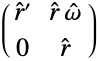

In [53]:
Transform = {{D[OverHat[r][OverHat[t]], OverHat[t]], OverHat[r][OverHat[t]] OverHat[\[Omega]][OverHat[t]]}, {0, OverHat[r][OverHat[t]]}};
Transform // MatrixForm // TraditionalForm

Итак правая часть энергетической системы запишется как

FormBox[TagBox[RowBox[{"(", "⁠", 

 
>         TagBox[GridBox[{{RowBox[{FractionBox["1", "2"], " ", 

 
>               OverscriptBox["r", "^"], " ", SubscriptBox["ϵ", "G"], " ", 

 
>               RowBox[{"(", RowBox[{RowBox[{OverscriptBox["r", "^"], " ", 

 
>                     OverscriptBox["ω", "^"], " ", 

 
>                     RowBox[{"(", RowBox[{RowBox[{RowBox[{"sin", "(", 

 
>                             RowBox[{"2", " ", "ϕ"}], ")"}], " ", 

 
>                           RowBox[{"(", 

 
>                             RowBox[{TemplateBox[List[SubscriptBox[

 
>                            OverscriptBox["f", "^"], 

 
>                            RowBox[List["x", ",", "x"]]], "\"(5)\""], 

 
>                             "Superscript", Rule[SyntaxForm, SuperscriptBox]], 

 
>                             "-", 

 
>                             TemplateBox[List[SubscriptBox[OverscriptB\

 
>   ox["f", "^"], RowBox[List["y", ",", "y"]]], "\"(5)\""], "Superscript", 

 
>                             Rule[SyntaxForm, SuperscriptBox]]}], ")"}]}], "-", 

 
>                         RowBox[{"2", " ", 

 
>                           RowBox[{"cos", "(", RowBox[{"2", " ", "ϕ"}], ")"}], 

 
>                           " ", TemplateBox[List[SubscriptBox[OverscriptB\

 
>   ox["f", "^"], RowBox[List["x", ",", "y"]]], "\"(5)\""], "Superscript", 

 
>                            Rule[SyntaxForm, SuperscriptBox]]}]}], ")"}]}], "-", 

 
>                   RowBox[{"2", " ", SuperscriptBox[OverscriptBox["r", "^"], "′"], 

 
>                     " ", RowBox[{"(", 

 
>                       RowBox[{RowBox[{RowBox[{"sin", "(", 

 
>                             RowBox[{"2", " ", "ϕ"}], ")"}], " ", 

 
>                           TemplateBox[List[SubscriptBox[OverscriptBox["f", 

 
>                             "^"], RowBox[List["x", ",", "y"]]], "\"(5)\""], 

 
>                            "Superscript", Rule[SyntaxForm, SuperscriptBox]]}], 

 
>                         "+", RowBox[{RowBox[{SuperscriptBox["cos", "2"], "(", 

 
>                             "ϕ", ")"}], " ", 

 
>                           TemplateBox[List[SubscriptBox[OverscriptBox["f", 

 
>                             "^"], RowBox[List["x", ",", "x"]]], "\"(5)\""], 

 
>                            "Superscript", Rule[SyntaxForm, SuperscriptBox]]}], 

 
>                         "+", RowBox[{RowBox[{SuperscriptBox["sin", "2"], "(", 

 
>                             "ϕ", ")"}], " ", 

 
>                           TemplateBox[List[SubscriptBox[OverscriptBox["f", 

 
>                             "^"], RowBox[List["y", ",", "y"]]], "\"(5)\""], 

 
>                            "Superscript", Rule[SyntaxForm, SuperscriptBox]]}]}], 

 
>                       ")"}]}]}], ")"}]}]}, 

 
>            {RowBox[{RowBox[{"-", FractionBox["1", "2"]}], " ", 

 
>               SuperscriptBox[OverscriptBox["r", "^"], "2"], " ", 

 
>               SubscriptBox["ϵ", "G"], " ", 

 
>               RowBox[{"(", RowBox[{RowBox[{RowBox[{"sin", "(", 

 
>                       RowBox[{"2", " ", "ϕ"}], ")"}], " ", 

 
>                     RowBox[{"(", RowBox[{TemplateBox[List[SubscriptBox[

 
>                            OverscriptBox["f", "^"], 

 
>                            RowBox[List["y", ",", "y"]]], "\"(5)\""], 

 
>                          "Superscript", Rule[SyntaxForm, SuperscriptBox]], "-", 

 
>                         TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>                            RowBox[List["x", ",", "x"]]], "\"(5)\""], 

 
>                          "Superscript", Rule[SyntaxForm, SuperscriptBox]]}], ")"}]}\

 
>   ], "+", RowBox[{"2", " ", RowBox[{"cos", "(", RowBox[{"2", " ", "ϕ"}], ")"}], 

 
>                     " ", TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>                        RowBox[List["x", ",", "y"]]], "\"(5)\""], "Superscript", 

 
>                      Rule[SyntaxForm, SuperscriptBox]]}]}], ")"}]}]}}, 

 
>       
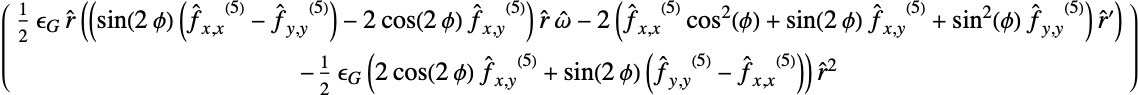

In [55]:
RHSEnegry = FullSimplify[Transform . RHSMotion, Trig -> True];
RHSEnegry // MatrixForm // TraditionalForm

## **Другой Способ** получения уравнений движения и энергетических уравнений через лагранжев формализм в полярных координатах

### **Лагранжиан системы**
Лагранжиан $L$ в полярных координатах $(r, \phi)$ выражается как:
$$
L = T - (U + \mu\Phi),
$$
где:
- $T$ — кинетическая энергия,
- $U$ — потенциальная энергия
- $\Phi = \frac{1}{5}f_{ij}^{(5)}r_i r_j = \frac{\epsilon_G}{2}\frac{b^2}{t_0^2}\hat{f}_{ij}^{(5)}\hat{r}_i \hat{r}_j = \frac{5}{2}\epsilon_G\frac{GM}{b}\hat{\Phi}$ - малый потенциал "реакции излучения"

Безразмерный малый потенциал "реакции излучения" $\hat{\Phi} = \frac{1}{5}\hat{f}_{ij}^{(5)}\hat{r}_i\hat{r}_j$

В ближней зоне грав. источника будем иметь $\mu \Phi \ll U$.
Откуда получаем $\frac{5}{2}\epsilon_{G}\hat{r}\hat{\Phi} \ll 1$.

<span style="color:red">**TODO_2:**</span> Для достаточно больших $\hat{r}$, но все еще в ближней зоне может оказаться, что
$\hat{r}\hat{\Phi} \ll 1$, так как $\hat{f}_{ij}$ очень медленно меняется.
Следовательно условие $\epsilon_G \ll 1$ необязательно.

FormBox[RowBox[{FractionBox["1", "5"], " ", 

 
>        RowBox[{"(", RowBox[{RowBox[{OverscriptBox["r", "^"], " ", 

 
>              RowBox[{"cos", "(", "ϕ", ")"}], " ", 

 
>              RowBox[{"(", RowBox[{RowBox[{OverscriptBox["r", "^"], " ", 

 
>                    RowBox[{"sin", "(", "ϕ", ")"}], " ", 

 
>                    TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>                       RowBox[List["x", ",", "y"]]], "\"(5)\""], "Superscript", 

 
>                     Rule[SyntaxForm, SuperscriptBox]]}], "+", 

 
>                  RowBox[{OverscriptBox["r", "^"], " ", 

 
>                    RowBox[{"cos", "(", "ϕ", ")"}], " ", 

 
>                    TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>                       RowBox[List["x", ",", "x"]]], "\"(5)\""], "Superscript", 

 
>                     Rule[SyntaxForm, SuperscriptBox]]}]}], ")"}]}], "+", 

 
>            RowBox[{OverscriptBox["r", "^"], " ", RowBox[{"sin", "(", "ϕ", ")"}], " ", 

 
>              RowBox[{"(", RowBox[{RowBox[{OverscriptBox["r", "^"], " ", 

 
>                    RowBox[{"cos", "(", "ϕ", ")"}], " ", 

 
>                    TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>                       RowBox[List["x", ",", "y"]]], "\"(5)\""], "Superscript", 

 
>                     Rule[SyntaxForm, SuperscriptBox]]}], "+", 

 
>                  RowBox[{OverscriptBox["r", "^"], " ", RowBox[{"sin", "(", "ϕ", ")"}],\
 
>    
                 " ", TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>                       RowBox[List["y", ",", "y"]]], "\"(5)\""], "Superscript", 

 
>                     Rule[SyntaxForm, SuperscriptBox]]}]}], ")"}]}]}], ")"}]}], 

 
>      TraditionalForm]
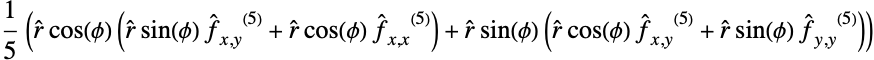

In [57]:
fh5rhrh = 1/5 EinsteinSummation[{{i, j}, {i}, {j}}, {fh5, rh, rh}];
fh5rhrh // TraditionalForm

Безразмерный лагранжиан

$$
\hat{L} = \hat{T} - (\hat{U} + \frac{5}{2}\epsilon_G\hat{\Phi}),
$$
или
$$
\hat{L} = \frac{1}{2} \left((\hat{r}^{(1)})^2 + \hat{r}^2 \hat{\omega}^2 \right) + \frac{1}{\hat{r}} - \frac{\epsilon_G}{2}\hat{f}_{ij}^{(5)}\hat{r}_i \hat{r}_j.
$$

### **Уравнения Эйлера-Лагранжа**
Уравнения Эйлера-Лагранжа имеют вид:
$$
\frac{d}{dt} \left( \frac{\partial \hat{L}}{\partial \dot{q}_i} \right) - \frac{\partial \hat{L}}{\partial q_i} = 0,
$$
где $q_i$ — обобщённые координаты ($\hat{r}$ и $\phi$).

---

#### Уравнение для координаты $\hat{r}$:
$$
\frac{d}{d\hat{t}} \left(\frac{\partial \hat{L}}{\partial \hat{r}^{(1)}} \right) - \frac{\partial \hat{L}}{\partial \hat{r}} = 0.
$$
Вычислим производные:
$$
\frac{\partial \hat{L}}{\partial \hat{r}^{(1)}} = \hat{r}^{(1)}, \quad \frac{d}{d\hat{t}} \left( \frac{\partial \hat{L}}{\partial \hat{r}^{(1)}} \right) = \hat{r}^{(2)},
$$
$$
\frac{\partial \hat{L}}{\partial \hat{r}} = \hat{r} \hat{\omega}^2 - \frac{1}{\hat{r}^2} - \frac{5}{2}\epsilon_G\frac{\partial \hat{\Phi}}{\partial \hat{r}}.
$$
Подставляем в уравнение Эйлера-Лагранжа:
$$
\hat{r}^{(2)} - \hat{r} \hat{\omega}^2 + \frac{1}{\hat{r}^2} = - \frac{5}{2}\epsilon_G\frac{\partial \hat{\Phi}}{\partial \hat{r}}.
$$

Это **радиальное уравнение движения**.

Здесь 
$$
\frac{\partial \hat{\Phi}}{\partial \hat{r}} = \frac{1}{5}\hat{f}_{ij}^{(5)}\left(\frac{\partial \hat{r}_i}{\partial \hat{r}}\hat{r}_j + \hat{r}_i\frac{\partial \hat{r}_j}{\partial \hat{r}}\right)
$$

Правая часть радиального уравнения движения будет выглядеть как

FormBox[RowBox[{OverscriptBox["r", "^"], " ", 

 
>        RowBox[{"(", RowBox[{"-", SubscriptBox["ϵ", "G"]}], ")"}], " ", 

 
>        RowBox[{"(", RowBox[{RowBox[{RowBox[{"sin", "(", RowBox[{"2", " ", "ϕ"}], 

 
>                ")"}], " ", TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>                 RowBox[List["x", ",", "y"]]], "\"(5)\""], "Superscript", 

 
>               Rule[SyntaxForm, SuperscriptBox]]}], "+", 

 
>            RowBox[{RowBox[{SuperscriptBox["cos", "2"], "(", "ϕ", ")"}], " ", 

 
>              TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>                 RowBox[List["x", ",", "x"]]], "\"(5)\""], "Superscript", 

 
>               Rule[SyntaxForm, SuperscriptBox]]}], "+", 

 
>            RowBox[{RowBox[{SuperscriptBox["sin", "2"], "(", "ϕ", ")"}], " ", 

 
>              TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>                 RowBox[List["y", ",", "y"]]], "\"(5)\""], "Superscript", 

 
>               Rule[SyntaxForm, SuperscriptBox]]}]}], ")"}]}], TraditionalForm]
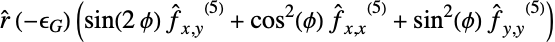

In [59]:
RHSMotionRadialLagrange = - 1/2 Subscript[\[Epsilon], G] FullSimplify[EinsteinSummation[{{i, j}, {i}, {j}}, {fh5, D[rh, OverHat[r][OverHat[t]]], rh}] + EinsteinSummation[{{i, j}, {i}, {j}}, {fh5, rh, D[rh, OverHat[r][OverHat[t]]]}]];
RHSMotionRadialLagrange // TraditionalForm

<span style="color:brown">**NB:**</span> Выражение <span style="color:green">**совпадает**</span> с раннее полученным уравнением и с уравнением (10) из файла Binary.pdf

In [60]:
RHSMotion[[1]] - RHSMotionRadialLagrange

0

---

#### Уравнение для координаты $\phi$:
$$
\frac{d}{d\hat{t}} \left(\frac{\partial \hat{L}}{\partial \hat{\omega}} \right) - \frac{\partial \hat{L}}{\partial \phi} = 0.
$$
Вычислим производные:
$$
\frac{\partial \hat{L}}{\partial \hat{\omega}} = \hat{r}^2 \hat{\omega}, \quad \frac{d}{d\hat{t}} \left( \frac{\partial \hat{L}}{\partial \hat{\omega}} \right) = \frac{d}{d\hat{t}} \left( \hat{r}^2 \hat{\omega} \right),
$$
$$
\frac{\partial \hat{L}}{\partial \phi} = - \frac{5}{2}\epsilon_G\frac{\partial \hat{\Phi}}{\partial \phi}.
$$
Подставляем в уравнение Эйлера-Лагранжа:
$$
\frac{1}{\hat{r}}\frac{d}{d\hat{t}} \left( \hat{r}^2 \hat{\omega} \right) = \frac{1}{\hat{r}}\frac{d\hat{J}}{d\hat{t}} = - \frac{5}{2}\frac{\epsilon_G}{\hat{r}}\frac{\partial \hat{\Phi}}{\partial \phi}.
$$

Здесь 
$$
\frac{\partial \hat{\Phi}}{\partial \phi} = \frac{1}{5}\hat{f}_{ij}^{(5)}\left(\frac{\partial \hat{r}_i}{\partial \phi}\hat{r}_j + \hat{r}_i\frac{\partial \hat{r}_j}{\partial \phi}\right)
$$

Правая часть уравнения движения для $\phi$ будет выглядеть как

FormBox[RowBox[{RowBox[{"-", FractionBox["1", "2"]}], " ", OverscriptBox["r", "^"], 

 
>        " ", SubscriptBox["ϵ", "G"], " ", 

 
>        RowBox[{"(", RowBox[{RowBox[{RowBox[{"sin", "(", RowBox[{"2", " ", "ϕ"}], 

 
>                ")"}], " ", RowBox[{"(", 

 
>                RowBox[{TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>                     RowBox[List["y", ",", "y"]]], "\"(5)\""], "Superscript", 

 
>                   Rule[SyntaxForm, SuperscriptBox]], "-", 

 
>                  TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>                     RowBox[List["x", ",", "x"]]], "\"(5)\""], "Superscript", 

 
>                   Rule[SyntaxForm, SuperscriptBox]]}], ")"}]}], "+", 

 
>            RowBox[{"2", " ", RowBox[{"cos", "(", RowBox[{"2", " ", "ϕ"}], ")"}], " ", 

 
>              TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>                 RowBox[List["x", ",", "y"]]], "\"(5)\""], "Superscript", 

 
>               Rule[SyntaxForm, SuperscriptBox]]}]}], ")"}]}], TraditionalForm]
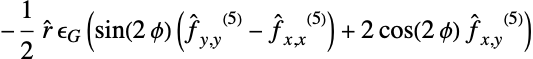

In [62]:
RHSMotionPhiLagrange = - 1/2 Subscript[\[Epsilon], G] FullSimplify[EinsteinSummation[{{i, j}, {i}, {j}}, {fh5, D[rh, \[Phi][OverHat[t]]], rh}] + EinsteinSummation[{{i, j}, {i}, {j}}, {fh5, rh, D[rh, \[Phi][OverHat[t]]]}]]/OverHat[r][OverHat[t]];
RHSMotionPhiLagrange // TraditionalForm

<span style="color:brown">**NB:**</span> Выражение <span style="color:green">**совпадает**</span> с раннее полученным уравнением и с уравнением (9) из файла Binary.pdf

In [63]:
RHSMotion[[2]] - RHSMotionPhiLagrange

0

## Получим **энергетическую** систему уравнений в подходе Лагранжа

Заметим, что энергия системы:
$$
\hat{E} = \frac{(\hat{r}^{(1)})^2}{2} + \frac{\hat{r}^2 \hat{\omega}^2}{2} - \frac{1}{\hat{r}}
$$
$$
\frac{1}{\hat{r}^{(1)}}\left(\frac{d\hat{E}}{d\hat{t}} - \hat{\omega} \frac{d\hat{J}}{d\hat{t}}\right) = \hat{r}^{(2)} - \hat{r} \hat{\omega}^2 + \frac{1}{\hat{r}^2}
$$

А также уравнение для изменения момента импульса системы есть
$$
\frac{d\hat{J}}{d\hat{t}} = - \frac{5}{2}\epsilon_G\frac{\partial \hat{\Phi}}{\partial \phi}.
$$

Итоговая энергетическая система, выведенная по-новому будет записываться как:

$$
\begin{align}
\frac{d\hat{E}}{d\hat{t}} &= - \frac{5}{2}\epsilon_G\left(\hat{r}^{(1)}\frac{\partial \hat{\Phi}}{\partial \hat{r}} + \hat{\omega} \frac{\partial \hat{\Phi}}{\partial \phi}\right)
  = - \frac{\epsilon_G}{2}\hat{f}_{ij}^{(5)}\left(\frac{d\hat{r}_i}{d\hat{t}}\hat{r}_j + \hat{r}_i\frac{d\hat{r}_j}{d\hat{t}}\right)
  = - \frac{\epsilon_G}{2}\hat{f}_{ij}^{(5)}\frac{d(\hat{r}_i \hat{r}_j)}{d\hat{t}}
\\
\frac{d\hat{J}}{d\hat{t}} &= - \frac{5}{2}\epsilon_G\frac{\partial \hat{\Phi}}{\partial \phi}
  = - \frac{\epsilon_G}{2}\hat{f}_{ij}^{(5)}\left(\frac{\partial \hat{r}_i}{\partial \phi}\hat{r}_j + \hat{r}_i\frac{\partial \hat{r}_j}{\partial \phi}\right)
  = - \frac{\epsilon_G}{2}\hat{f}_{ij}^{(5)}\frac{d(\hat{r}_i \hat{r}_j)}{d\phi}
\end{align}
$$

FormBox[TagBox[RowBox[{"(", "⁠", 

 
>         TagBox[GridBox[{{RowBox[{OverscriptBox["r", "^"], " ", 

 
>               RowBox[{"(", RowBox[{"-", SubscriptBox["ϵ", "G"]}], ")"}], " ", 

 
>               RowBox[{"(", RowBox[{RowBox[{OverscriptBox["r", "^"], " ", 

 
>                     OverscriptBox["ω", "^"], " ", 

 
>                     RowBox[{"(", RowBox[{RowBox[{RowBox[{"cos", "(", 

 
>                             RowBox[{"2", " ", "ϕ"}], ")"}], " ", 

 
>                           TemplateBox[List[SubscriptBox[OverscriptBox["f", 

 
>                             "^"], RowBox[List["x", ",", "y"]]], "\"(5)\""], 

 
>                            "Superscript", Rule[SyntaxForm, SuperscriptBox]]}], 

 
>                         "+", RowBox[{RowBox[{"sin", "(", "ϕ", ")"}], " ", 

 
>                           RowBox[{"cos", "(", "ϕ", ")"}], " ", 

 
>                           RowBox[{"(", 

 
>                             RowBox[{TemplateBox[List[SubscriptBox[

 
>                             OverscriptBox["f", "^"], 

 
>                             RowBox[List["y", ",", "y"]]], "\"(5)\""], 

 
>                             "Superscript", Rule[SyntaxForm, SuperscriptBox]], 

 
>                              "-", 

 
>                              TemplateBox[List[SubscriptBox[OverscriptB\

 
>   ox["f", "^"], RowBox[List["x", ",", "x"]]], "\"(5)\""], "Superscript", 

 
>                              Rule[SyntaxForm, SuperscriptBox]]}], ")"}]}]}], ")"}]\

 
>   }], "+", RowBox[{SuperscriptBox[OverscriptBox["r", "^"], "′"], " ", 

 
>                     RowBox[{"(", RowBox[{RowBox[{RowBox[{"sin", "(", 

 
>                             RowBox[{"2", " ", "ϕ"}], ")"}], " ", 

 
>                           TemplateBox[List[SubscriptBox[OverscriptBox["f", 

 
>                             "^"], RowBox[List["x", ",", "y"]]], "\"(5)\""], 

 
>                            "Superscript", Rule[SyntaxForm, SuperscriptBox]]}], 

 
>                         "+", RowBox[{RowBox[{SuperscriptBox["cos", "2"], "(", 

 
>                             "ϕ", ")"}], " ", 

 
>                           TemplateBox[List[SubscriptBox[OverscriptBox["f", 

 
>                             "^"], RowBox[List["x", ",", "x"]]], "\"(5)\""], 

 
>                            "Superscript", Rule[SyntaxForm, SuperscriptBox]]}], 

 
>                         "+", RowBox[{RowBox[{SuperscriptBox["sin", "2"], "(", 

 
>                             "ϕ", ")"}], " ", 

 
>                           TemplateBox[List[SubscriptBox[OverscriptBox["f", 

 
>                             "^"], RowBox[List["y", ",", "y"]]], "\"(5)\""], 

 
>                            "Superscript", Rule[SyntaxForm, SuperscriptBox]]}]}], 

 
>                       ")"}]}]}], ")"}]}]}, 

 
>            {RowBox[{RowBox[{"-", FractionBox["1", "2"]}], " ", 

 
>               SuperscriptBox[OverscriptBox["r", "^"], "2"], " ", 

 
>               SubscriptBox["ϵ", "G"], " ", 

 
>               RowBox[{"(", RowBox[{RowBox[{RowBox[{"sin", "(", 

 
>                       RowBox[{"2", " ", "ϕ"}], ")"}], " ", 

 
>                     RowBox[{"(", RowBox[{TemplateBox[List[SubscriptBox[

 
>                            OverscriptBox["f", "^"], 

 
>                            RowBox[List["y", ",", "y"]]], "\"(5)\""], 

 
>                          "Superscript", Rule[SyntaxForm, SuperscriptBox]], "-", 

 
>                         TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>                            RowBox[List["x", ",", "x"]]], "\"(5)\""], 

 
>                          "Superscript", Rule[SyntaxForm, SuperscriptBox]]}], ")"}]}\

 
>   ], "+", RowBox[{"2", " ", RowBox[{"cos", "(", RowBox[{"2", " ", "ϕ"}], ")"}], 

 
>                     " ", TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>                        RowBox[List["x", ",", "y"]]], "\"(5)\""], "Superscript", 

 
>                      Rule[SyntaxForm, SuperscriptBox]]}]}], ")"}]}]}}, 

 
>           Rule[
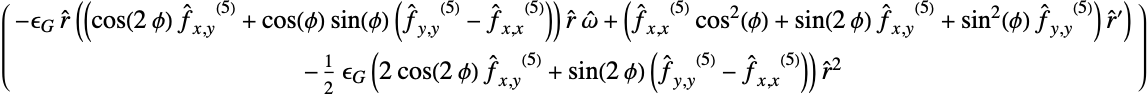

In [65]:
RHSEnegryLagrange = - 5/2 Subscript[\[Epsilon],G] FullSimplify[{
  D[fh5rhrh, OverHat[t]] /. OmegaReplace,
  D[fh5rhrh, \[Phi][OverHat[t]]]
}, Trig -> True];

RHSEnegryLagrange // MatrixForm // TraditionalForm

<span style="color:brown">**NB:**</span> Выражения полностью <span style="color:green">**совпадают**</span> с предыдущим ньютоновым подходом!

0

0
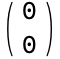

In [66]:
FullSimplify[RHSEnegryLagrange - RHSEnegry] // MatrixForm

В **размерной** же записи наши уравнения превращаются в
$$
\begin{align}
\frac{dE}{dt} &=
  = - \frac{1}{5}f_{ij}^{(5)} \mu \frac{d(r_i r_j)}{dt}
  = - \frac{1}{5}\frac{c^5}{G}f_{ij}^{(5)} \frac{d}{dt}\left(f_{ij} + \frac{1}{3} \delta_{ij}r^2\right)
  = - \frac{1}{5}\frac{c^5}{G}f_{ij}^{(5)} \frac{df_{ij}}{dt}
\\
\frac{dJ}{dt} &=
  = - \frac{1}{5}f_{ij}^{(5)} \mu \frac{d(r_i r_j)}{d\phi}
  = - \frac{1}{5}\frac{c^5}{G}f_{ij}^{(5)} \frac{d}{d\phi}\left(f_{ij} + \frac{1}{3} \delta_{ij}r^2\right)
  = - \frac{1}{5}\frac{c^5}{G}f_{ij}^{(5)} \frac{df_{ij}}{d\phi}
  = - \frac{2}{5}\frac{c^5}{G}\epsilon_{ij}f_{ik}^{(5)} f_{kj}
\end{align}
$$

Здесь учтено, что квадрупольный момент бесследовый
$$
\begin{align}
\text{Tr}(f_{ij}) &= \delta_{ij}f_{ij} = 0
\\
\text{Tr}(f^{(5)}_{ij}) &= \delta_{ij}f^{(5)}_{ij} = 0
\\
\end{align}
$$

FormBox[RowBox[{RowBox[{"-", FractionBox["1", "5"]}], " ", 

 
>        SuperscriptBox[OverscriptBox["r", "^"], "2"], " ", 

 
>        RowBox[{"(", RowBox[{RowBox[{RowBox[{"sin", "(", RowBox[{"2", " ", "ϕ"}], 

 
>                ")"}], " ", RowBox[{"(", 

 
>                RowBox[{TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>                     RowBox[List["x", ",", "x"]]], "\"(5)\""], "Superscript", 

 
>                   Rule[SyntaxForm, SuperscriptBox]], "-", 

 
>                  TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>                     RowBox[List["y", ",", "y"]]], "\"(5)\""], "Superscript", 

 
>                   Rule[SyntaxForm, SuperscriptBox]]}], ")"}]}], "-", 

 
>            RowBox[{"2", " ", RowBox[{"cos", "(", RowBox[{"2", " ", "ϕ"}], ")"}], " ", 

 
>              TemplateBox[List[SubscriptBox[OverscriptBox["f", "^"], 

 
>                 RowBox[List["x", ",", "y"]]], "\"(5)\""], "Superscript", 

 
>               Rule[SyntaxForm, SuperscriptBox]]}]}], ")"}]}], TraditionalForm]
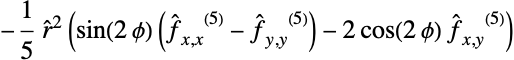

In [69]:
(* Доказатество последнего равенства в уравнении для изменениия момента импульса *)
leviCivitaArray = Normal[LeviCivitaTensor[2]];
-2/5 FullSimplify[EinsteinSummation[{{i, j}, {i, k}, {k, j}}, {leviCivitaArray, fh5, fh}]] // TraditionalForm

<span style="color:brown">**NB:**</span> Выражения полностью <span style="color:green">**совпадают**</span>
с $dE/dt, dJ/dt$ из задачника Лайтман А., Пресс В., Прайс Р., Тюкольки С. - 1979 - Сборник задач по теории относительности и гравитации (Решение задачи 18.5, стр. 446-447)

Не стоит забывать, что в задачнике система геометризированных единиц $G = c = 1$.

# Итоговая система **энергетических** уравнений:

$$
\begin{align}
\tag{dJ/dt}
\frac{d\hat{J}}{d\hat{t}} &= -\frac{1}{2} \epsilon_G
\hat{r}^2
\left(
  \sin (2 \phi ) \left(\hat{f}_{y,y}{}^{\text{(5)}}-\hat{f}_{x,x}{}^{\text{(5)}}\right)+2 \cos (2 \phi ) \hat{f}_{x,y}{}^{\text{(5)}}
\right)
= \epsilon_G I_J
\\
\tag{dE/dt}
\frac{d\hat{E}}{d\hat{t}} &= \epsilon_G
\left(
  I_J\hat{\omega}
  -\hat{r} \hat{r}'
  \left(
  \sin (2 \phi ) \hat{f}_{x,y}{}^{\text{(5)}}+\cos ^2(\phi ) \hat{f}_{x,x}{}^{\text{(5)}}+\sin ^2(\phi ) \hat{f}_{y,y}{}^{\text{(5)}}
  \right)
\right)
= \epsilon_G I_E
\end{align}
$$

# RHS уравнения (dJ/dt)

Введём новое обозначение $\hat{r}^2 \equiv \hat{r}_2$

In [70]:
ToR2Replacement = {
  OverHat[r][OverHat[t]] -> Sqrt[Subscript[OverHat[r],2][OverHat[t]]],
  Derivative[n_][OverHat[r]][OverHat[t]] :> D[Sqrt[Subscript[OverHat[r], 2][OverHat[t]]], {OverHat[t], n}]
};

и подставим в (dJ/dt) значения $\hat{f}_{i,j}^{(5)}$:

FormBox[RowBox[{SubscriptBox[OverscriptBox["r", "^"], "2"], " ", 

 
>        RowBox[{"(", RowBox[{RowBox[{"-", 

 
>              RowBox[{"5", " ", SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], 

 
>                  "2"], "′"], " ", SuperscriptBox[OverscriptBox["ω", "^"], "′′′"]}]}], 

 
>            "-", RowBox[{"10", " ", SuperscriptBox[SubscriptBox[OverscriptBox["r", 

 
>                 "^"], "2"], "′′′"], " ", SuperscriptBox[OverscriptBox["ω", "^"],\
 
>    "′"]}]\
, "+", RowBox[{"120", " ", SuperscriptBox[OverscriptBox["ω", "^"], "2"], "\
 
>    ", 
           SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], "2"], "′"], "\
 
>    ", 
           SuperscriptBox[OverscriptBox["ω", "^"], "′"]}], "+", 

 
>            RowBox[{"60", " ", SubscriptBox[OverscriptBox["r", "^"], "2"], " ", 

 
>              OverscriptBox["ω", "^"], " ", 
           SuperscriptBox[RowBox[{"(", 

 
>                 SuperscriptBox[OverscriptBox["ω", "^"], "′"], ")"}], "2"]}], "+", 

 
>            RowBox[{"40", " ", SuperscriptBox[OverscriptBox["ω", "^"], "3"], " ", 

 
>              SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], "2"], "′′"]}], "+", 

 
>            RowBox[{"40", " ", SubscriptBox[OverscriptBox["r", "^"], "2"], " ", 

 
>              SuperscriptBox[OverscriptBox["ω", "^"], "2"], " ", 

 
>              SuperscriptBox[OverscriptBox["ω", "^"], "′′"]}], "-", 

 
>            RowBox[{"10", " ", SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], 

 
>                "2"], "′′"], " ", SuperscriptBox[OverscriptBox["ω", "^"], "′′"]}], "-",\
 
>    
         RowBox[{"5", " ", OverscriptBox["ω", "^"], " ", 

 
>              SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], "2"], "′′′′"]}],\
 
>    "-", 
         RowBox[{SubscriptBox[OverscriptBox["r", "^"], "2"], " ", 

 
>              SuperscriptBox[OverscriptBox["ω", "^"], "′′′′"]}], "-", 

 
>            RowBox[{RowBox[{"16"}], " ", SubscriptBox[OverscriptBox["r", "^"], "2"], 

 
>              " ", SuperscriptBox[OverscriptBox["ω", "^"], "5"]}]}], ")"}]}], 

 
>      TraditionalForm]
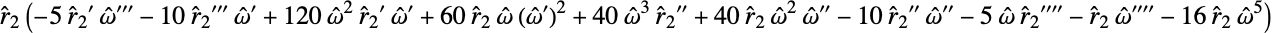

In [76]:
fh1 = fh /. ToR2Replacement;
fh5Symbolic = Simplify[D[fh1, {OverHat[t], 5}], Trig -> True];

Fh5Replacement = Flatten[{
  Outer[
    Superscript[Subscript[OverHat[f], #1, #2], "(5)"] -> fh5Symbolic[[#1 /. {x -> 1, y -> 2}, #2 /. {x -> 1, y -> 2}]] &,
    {x, y}, {x, y}
  ],
  ToR2Replacement,
  OmegaReplace
}];

dJdtTemp = RHSEnegryLagrange[[2]] //. Fh5Replacement;
dJdt = Subscript[OverHat[r],2][OverHat[t]]*Expand[Simplify[dJdtTemp/Subscript[\[Epsilon], G], Trig -> True]/Subscript[OverHat[r],2][OverHat[t]]];
dJdt // TraditionalForm

<span style="color:brown">**NB:**</span> В файле Binary.pdf выводится <span style="color:green">**точно такое же**</span> выражение

$$
I_J = I_1 = \hat{r}_2 \left[ 120\hat{r}_2^{(1)}\hat{\omega}^2\hat{\omega}^{(1)} - 5\hat{r}_2^{(1)}\hat{\omega}^{(3)} - 16\hat{r}_2\hat{\omega}^5 - 10\hat{r}_2^{(2)}\hat{\omega}^{(2)} + 60\hat{r}_2\hat{\omega}(\hat{\omega}^{(1)})^2
- 10\hat{r}_2^{(3)}\hat{\omega}^{(1)} + 40\hat{r}_2^{(2)}\hat{\omega}^3 - 5\hat{r}_2^{(4)}\hat{\omega} - \hat{r}_2\hat{\omega}^{(4)} + 40\hat{r}_2\hat{\omega}^2\hat{\omega}^{(2)} \right]
$$

In [78]:
I1 = Subscript[OverHat[r], 2][OverHat[t]] * (
    120 * Derivative[1][Subscript[OverHat[r], 2]][OverHat[t]] *
    OverHat[\[Omega]][OverHat[t]]^2 * Derivative[1][OverHat[\[Omega]]][OverHat[t]]
    - 5 * Derivative[1][Subscript[OverHat[r], 2]][OverHat[t]] *
    Derivative[3][OverHat[\[Omega]]][OverHat[t]]
    - 16 * Subscript[OverHat[r], 2][OverHat[t]] *
    OverHat[\[Omega]][OverHat[t]]^5
    - 10 * Derivative[2][Subscript[OverHat[r], 2]][OverHat[t]] *
    Derivative[2][OverHat[\[Omega]]][OverHat[t]]
    + 60 * Subscript[OverHat[r], 2][OverHat[t]] *
    OverHat[\[Omega]][OverHat[t]] * Derivative[1][OverHat[\[Omega]]][OverHat[t]]^2
    - 10 * Derivative[3][Subscript[OverHat[r], 2]][OverHat[t]] *
    Derivative[1][OverHat[\[Omega]]][OverHat[t]]
    + 40 * Derivative[2][Subscript[OverHat[r], 2]][OverHat[t]] *
    OverHat[\[Omega]][OverHat[t]]^3
    - 5 * Derivative[4][Subscript[OverHat[r], 2]][OverHat[t]] *
    OverHat[\[Omega]][OverHat[t]]
    - Subscript[OverHat[r], 2][OverHat[t]] *
    Derivative[4][OverHat[\[Omega]]][OverHat[t]]
    + 40 * Subscript[OverHat[r], 2][OverHat[t]] *
    OverHat[\[Omega]][OverHat[t]]^2 * Derivative[2][OverHat[\[Omega]]][OverHat[t]]
);
dJdt - I1

0

# RHS уравнения (dE/dt)

Подставим в (dE/dt) значения $\hat{f}_{i,j}^{(5)}$:

FormBox[RowBox[{FractionBox["1", "3"], " ", 

 
>        RowBox[{"(", RowBox[{RowBox[{OverscriptBox["ω", "^"], " ", 

 
>              RowBox[{"(", RowBox[{RowBox[{"-", 

 
>                    RowBox[{"3", " ", SubscriptBox[OverscriptBox["r", "^"], "2"], 

 
>                      " ", RowBox[{"(", 

 
>                        RowBox[{RowBox[{"10", " ", 

 
>                            SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], 

 
>                              "2"], "′′′"], " ", 

 
>                            SuperscriptBox[OverscriptBox["ω", "^"], "′"]}], "+", 

 
>                          RowBox[{"10", " ", 

 
>                            SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], 

 
>                              "2"], "′′"], " ", 

 
>                            SuperscriptBox[OverscriptBox["ω", "^"], "′′"]}], "+", 

 
>                          RowBox[{SubscriptBox[OverscriptBox["r", "^"], "2"], " ", 

 
>                            SuperscriptBox[OverscriptBox["ω", "^"], "′′′′"]}]}], ")"}]\

 
>   }]}], "+", RowBox[{"60", " ", SuperscriptBox[RowBox[{"(", 

 
>                       SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], "2"], 

 
>                        "′"], ")"}], "2"], " ", 

 
>                    SuperscriptBox[OverscriptBox["ω", "^"], "′′"]}], "+", 

 
>                  RowBox[{"90", " ", 

 
>                    SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], "2"], "′"], 

 
>                    " ", SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], "2"], 

 
>                     "′′"], " ", SuperscriptBox[OverscriptBox["ω", "^"], "′"]}]}],\
 
>    ")"}]\
}], "+", RowBox[{SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], "2"],\
 
>    "′"], 
           " ", RowBox[{"(", RowBox[{RowBox[{"30", " ", 

 
>                    SubscriptBox[OverscriptBox["r", "^"], "2"], " ", 

 
>                    SuperscriptBox[OverscriptBox["ω", "^"], "′"], " ", 

 
>                    SuperscriptBox[OverscriptBox["ω", "^"], "′′"]}], "+", 

 
>                  RowBox[{"45", " ", 

 
>                    SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], "2"], "′"], 

 
>                    " ", SuperscriptBox[RowBox[{"(", 

 
>                       SuperscriptBox[OverscriptBox["ω", "^"], "′"], ")"}], "2"]}], 

 
>                  "-", SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], "2"], 

 
>                   "′′′′′"]}], ")"}]}], "-", 

 
>            RowBox[{"60", " ", SuperscriptBox[OverscriptBox["ω", "^"], "4"], " ", 

 
>              RowBox[{"(", RowBox[{SuperscriptBox[RowBox[{"(", 

 
>                     SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], "2"], 

 
>                      "′"], ")"}], "2"], "-", 

 
>                  RowBox[{"2", " ", SubscriptBox[OverscriptBox["r", "^"], "2"], " ", 

 
>                    SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], "2"],\
 
>    "′′"]}]}\
], ")"}]}], "+", RowBox[{"120", " ", SubscriptBox[OverscriptBox["r",\
 
>    "^"], "2"], 
           " ", SuperscriptBox[OverscriptBox["ω", "^"], "3"], " ", 

 
>              RowBox[{"(", RowBox[{RowBox[{"2", " ", 

 
>                    SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], "2"], "′"], 

 
>                    " ", SuperscriptBox[OverscriptBox["ω", "^"], "′"]}], "+", 

 
>                  RowBox[{SubscriptBox[OverscriptBox["r", "^"], "2"], " ", 

 
>                    SuperscriptBox[OverscriptBox["ω", "^"], "′′"]}]}], ")"}]}], "+", 

 
>            RowBox[{"15", " ", SuperscriptBox[OverscriptBox["ω", "^"], "2"], " ", 

 
>              RowBox[{"(", RowBox[{RowBox[{"12", " ", 

 
>                    SubsuperscriptBox[OverscriptBox["r", "^"], "2", "2"], " ", 

 
>                    SuperscriptBox[RowBox[{"(", 

 
>                       SuperscriptBox[OverscriptBox["ω", "^"], "′"], ")"}], "2"]}], 

 
>                  "+", RowBox[{"2", " ", 

 
>                    SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], "2"], "′"], 

 
>   
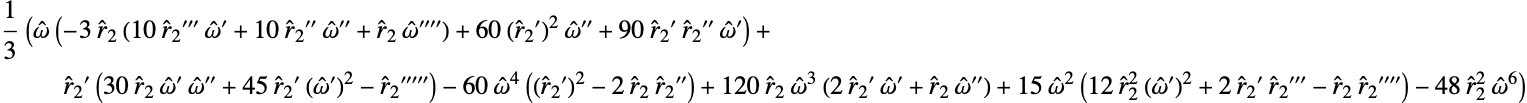

In [81]:
dEdtTemp = RHSEnegryLagrange[[1]] //. Fh5Replacement;
dEdt = Simplify[dEdtTemp/Subscript[\[Epsilon], G], Trig -> True];
dEdt // TraditionalForm

<span style="color:brown">**NB:**</span> В файлах Binary.pdf и binary_catch1.pdf выводится <span style="color:green">**точно такие же**</span> выражения для правой части (dE/dt),
а именно $I_E = I_1\hat{\omega} + I_2\frac{\dot{r}}{r}$, где
$$
I_2 = 2\hat{r}_2 \left[ -40\hat{r}_2\hat{\omega}^3\hat{\omega}^{(1)} - 20\hat{\omega}^4\hat{r}_2^{(1)} + 5\hat{r}_2\hat{\omega}\hat{\omega}^{(3)} + 10\hat{r}_2\hat{\omega}^{(1)}\hat{\omega}^{(2)} + 10\hat{\omega}^2\hat{r}_2^{(3)} + 30\hat{\omega}\hat{\omega}^{(1)}\hat{r}_2^{(2)} + 20\hat{\omega}\hat{\omega}^{(2)}\hat{r}_2^{(1)} + 15\hat{r}_2^{(1)}(\hat{\omega}^{(1)})^2 - \frac{1}{3}\hat{r}_2^{(5)} \right]
$$

In [83]:
I2 = 2 * Subscript[OverHat[r], 2][OverHat[t]] * (
    -40 * Subscript[OverHat[r], 2][OverHat[t]] *
    OverHat[\[Omega]][OverHat[t]]^3 * Derivative[1][OverHat[\[Omega]]][OverHat[t]]
    - 20 * OverHat[\[Omega]][OverHat[t]]^4 *
    Derivative[1][Subscript[OverHat[r], 2]][OverHat[t]]
    + 5 * Subscript[OverHat[r], 2][OverHat[t]] *
    OverHat[\[Omega]][OverHat[t]] * Derivative[3][OverHat[\[Omega]]][OverHat[t]]
    + 10 * Subscript[OverHat[r], 2][OverHat[t]] *
    Derivative[1][OverHat[\[Omega]]][OverHat[t]] *
    Derivative[2][OverHat[\[Omega]]][OverHat[t]]
    + 10 * OverHat[\[Omega]][OverHat[t]]^2 *
    Derivative[3][Subscript[OverHat[r], 2]][OverHat[t]]
    + 30 * OverHat[\[Omega]][OverHat[t]] *
    Derivative[1][OverHat[\[Omega]]][OverHat[t]] *
    Derivative[2][Subscript[OverHat[r], 2]][OverHat[t]]
    + 20 * OverHat[\[Omega]][OverHat[t]] *
    Derivative[2][OverHat[\[Omega]]][OverHat[t]] *
    Derivative[1][Subscript[OverHat[r], 2]][OverHat[t]]
    + 15 * Derivative[1][Subscript[OverHat[r], 2]][OverHat[t]] *
    Derivative[1][OverHat[\[Omega]]][OverHat[t]]^2
    - (1/3) * Derivative[5][Subscript[OverHat[r], 2]][OverHat[t]]
);
Simplify[(I2*D[OverHat[r][OverHat[t]], OverHat[t]]/OverHat[r][OverHat[t]] + I1*OverHat[\[Omega]][OverHat[t]] /. ToR2Replacement) - dEdt]

0

# Итоговые $I_J$, $I_E$

$$
\begin{align}
\tag{IJ}\
I_J &= \hat{r}_2 \left[ 120\hat{r}_2^{(1)}\hat{\omega}^2\hat{\omega}^{(1)} - 5\hat{r}_2^{(1)}\hat{\omega}^{(3)} - 16\hat{r}_2\hat{\omega}^5 - 10\hat{r}_2^{(2)}\hat{\omega}^{(2)} + 60\hat{r}_2\hat{\omega}(\hat{\omega}^{(1)})^2
- 10\hat{r}_2^{(3)}\hat{\omega}^{(1)} + 40\hat{r}_2^{(2)}\hat{\omega}^3 - 5\hat{r}_2^{(4)}\hat{\omega} - \hat{r}_2\hat{\omega}^{(4)} + 40\hat{r}_2\hat{\omega}^2\hat{\omega}^{(2)} \right]
\\
\tag{IE}
I_E &= I_J\hat{\omega} + \hat{r}_2^{(1)} \left[ -40\hat{r}_2\hat{\omega}^3\hat{\omega}^{(1)} - 20\hat{\omega}^4\hat{r}_2^{(1)} + 5\hat{r}_2\hat{\omega}\hat{\omega}^{(3)} + 10\hat{r}_2\hat{\omega}^{(1)}\hat{\omega}^{(2)} + 10\hat{\omega}^2\hat{r}_2^{(3)} + 30\hat{\omega}\hat{\omega}^{(1)}\hat{r}_2^{(2)} + 20\hat{\omega}\hat{\omega}^{(2)}\hat{r}_2^{(1)} + 15\hat{r}_2^{(1)}(\hat{\omega}^{(1)})^2 - \frac{1}{3}\hat{r}_2^{(5)} \right]
\end{align}
$$

# Попытка численного решения начального уравнения движения

$$
\hat{r}_k^{(2)} + \frac{\hat{r}_k}{\hat{r}^3} = - \epsilon_G\hat{f}_{ki}^{(5)}\hat{r}_i
$$

^
{{r -> InterpolatingFunction[{{0., 200.}}, <>], 
 
>    ϕ -> InterpolatingFunction[{{0., 200.}}, <>]}}
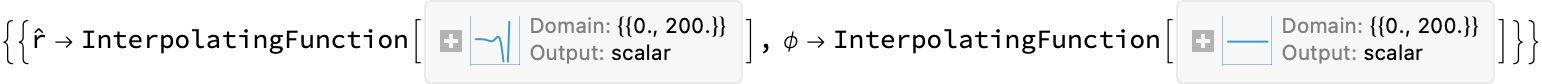

In [102]:
Clear[rxNum, ryNum, uxNum, uyNum, tMaxNum, rhRules, icsNum, MaxDNum, epsilonGNum]

rxNum = 10^2;
uxNum = -0.0;

(* зафиксированны *)
ryNum = 1;
uyNum = 0;

(* Newton *)
epsilonGNum = 0;
epsilonGNum = 0.1;
tMaxNum = 2*10^2;

rhNum = {
  Subscript[OverHat[r], "x"][OverHat[t]], Subscript[OverHat[r], "y"][OverHat[t]]
  };
D[rhNum, OverHat[t]];

rhRules[MaxDNum_] := Join[
  Thread[rhNum -> ({rxNum, ryNum} /. OverHat[t] -> 0)],
  Thread[D[rhNum, OverHat[t]] -> ({uxNum, uyNum} /. OverHat[t] -> 0)],
  Flatten[Table[
    Thread[D[rhNum, {OverHat[t], i}] -> {0, 0}],
    {i, 2, Max[MaxDNum, 2]}
  ]] /. OverHat[t] -> 0,
  {OverHat[t] -> 0}
];

icsNum[MaxDNum_] := Join[
  Simplify[Table[D[OverHat[r][OverHat[t]] -> Sqrt[rhNum.rhNum], {OverHat[t], i}], {i, 0, Max[MaxDNum, 1]}] //. rhRules[MaxDNum]],
  Simplify[Table[D[\[Phi][OverHat[t]] -> ArcTan[rhNum[[1]], rhNum[[2]]], {OverHat[t], i}], {i, 0, Max[MaxDNum, 1]}] //. rhRules[MaxDNum]]
];

fh5SymbolicNum = Simplify[D[fh, {OverHat[t], 5}], Trig -> True];

Fh5ReplacementNum = Flatten[{
  Outer[
    Superscript[Subscript[OverHat[f], #1, #2], "(5)"] -> fh5SymbolicNum[[#1 /. {x -> 1, y -> 2}, #2 /. {x -> 1, y -> 2}]] &,
    {x, y}, {x, y}
  ]
}];

sysNum = Simplify[D[rh, {OverHat[t], 2}] + rh/OverHat[r][OverHat[t]]^3 + epsilonGNum*fh5rh //. Fh5ReplacementNum];
eqnsNum = {sysNum[[1]] == 0, sysNum[[2]] == 0};
solNum = NDSolve[Join[eqnsNum, icsNum[If[epsilonGNum == 0, 1, 4]]] /. Rule -> Equal, {OverHat[r], \[Phi]}, {OverHat[t], 0, tMaxNum}
  (* WorkingPrecision -> 30,
  PrecisionGoal -> 20,
  AccuracyGoal -> 20,
  Method -> "StiffnessSwitching",
  MaxSteps -> 10^7 *)
]

-Graphics-
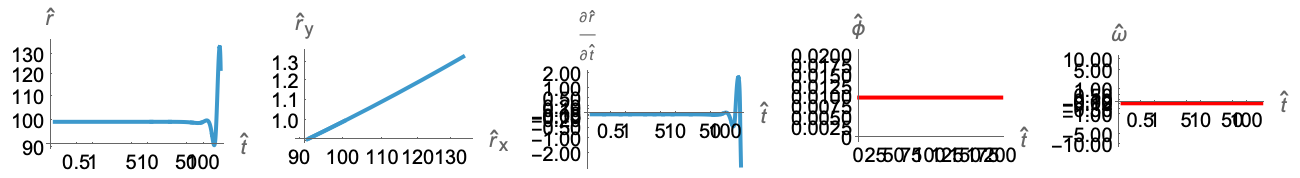

In [113]:
tMaxNum2 = tMaxNum;

RNum = OverHat[r][t] /. solNum[[1]];
PhiNum = \[Phi][t] /. solNum[[1]];
dRDtNum = D[OverHat[r][t] /. solNum[[1]], t];
OmegaNum = D[\[Phi][t] /. solNum[[1]], t];

PlotR = Plot[RNum, {t, 0, tMaxNum2},
  AxesLabel -> {TraditionalForm[OverHat[t]], TraditionalForm[OverHat[r]]},
  PlotRange -> All,
  ScalingFunctions -> {"Log", "Log"}
];

PlotRxRy = ParametricPlot[
  {RNum Cos[PhiNum], RNum Sin[PhiNum]},
  {t, 0, tMaxNum2},
  AxesLabel -> {TraditionalForm[Subscript[OverHat[r], "x"]], TraditionalForm[Subscript[OverHat[r], "y"]]},
  PlotRange -> All,
  ScalingFunctions -> {"SignedLog", "SignedLog"}
];

PlotDRDt = Plot[dRDtNum, {t, 0, tMaxNum2},
  AxesLabel -> {
  TraditionalForm[OverHat[t]],
  Style[TraditionalForm[HoldForm[D[OverHat[r], OverHat[t]]]], FontSize -> 7]
  },
  PlotRange -> All,
  ScalingFunctions -> {"Log", "SignedLog"}
];

PlotPhi = Plot[PhiNum, {t, 0, tMaxNum2},
  AxesLabel -> {TraditionalForm[OverHat[t]], TraditionalForm[OverHat[\[Phi]]]},
  PlotRange -> All,
  ScalingFunctions -> {"Linear", "Linear"},
  PlotStyle -> Red
];

PlotOmega = Plot[OmegaNum, {t, 0, tMaxNum2},
  AxesLabel -> {TraditionalForm[OverHat[t]], TraditionalForm[OverHat[\[Omega]]]},
  PlotRange -> All,
  ScalingFunctions -> {"Log", "SignedLog"},
  PlotStyle -> Red
];

GraphicsRow[{PlotR, PlotRxRy, PlotDRDt, PlotPhi, PlotOmega}]

-Graphics-
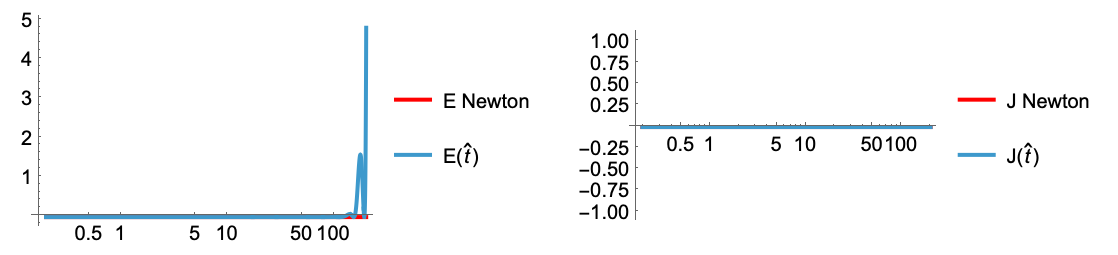

In [124]:
EnergyNewtonNum = Energy /. OverHat[\[Omega]][OverHat[t]] -> D[\[Phi][OverHat[t]], OverHat[t]] /. OverHat[t] -> 0 /. icsNum[1];

EnergyNum = Energy /. {
  OverHat[r][OverHat[t]] -> RNum,
  D[OverHat[r][OverHat[t]], OverHat[t]] -> dRDtNum,
  OverHat[\[Omega]][OverHat[t]] -> OmegaNum
  };

plotENewton = Plot[
  EnergyNewtonNum, {t, 0, tMaxNum2},
  PlotStyle -> Red,
  ScalingFunctions -> {"Log", "Linear"},
  PlotLegends -> {"E Newton"}
];

plotE = Plot[EnergyNum, {t, 0, tMaxNum2},
  AxesLabel -> {TraditionalForm[OverHat[t]], "E"},
  ScalingFunctions -> {"Log", "Linear"},
  PlotLegends -> {TraditionalForm["E"[OverHat[t]]]},
  PlotRange -> All
];

PlotsE = Show[plotENewton, plotE, PlotRange -> All];

AngularMomentumNewtonNum = AngularMomentum /. OverHat[\[Omega]][OverHat[t]] -> D[\[Phi][OverHat[t]], OverHat[t]] /. OverHat[t] -> 0 /. icsNum[1];

AngularMomentumNum = AngularMomentum /. {
  OverHat[r][OverHat[t]] -> RNum,
  OverHat[\[Omega]][OverHat[t]] -> OmegaNum
};

plotJNewton = Plot[
  AngularMomentumNewtonNum, {t, 0, tMaxNum2},
  PlotStyle -> Red,
  ScalingFunctions -> {"Log", "Linear"},
  PlotLegends -> {"J Newton"}
];

plotJ = Plot[AngularMomentumNum, {t, 0, tMaxNum2},
  AxesLabel -> {TraditionalForm[OverHat[t]], "J"},
  ScalingFunctions -> {"Log", "Linear"},
  PlotLegends -> {TraditionalForm["J"[OverHat[t]]]},
  PlotRange -> All
];

PlotsJ = Show[plotJNewton, plotJ, PlotRange -> All];

GraphicsRow[{PlotsE, PlotsJ}]

<span style="color:brown">**NB:**</span> Как можно видеть, численное решение при помощи Mathematica с участием пятой производной по времени пока не выполнимая задача.

# Потеря энергии за один период обращения

Энергию гравитационного излучени невозможно локализовать в области меньше длины одной волны.

Поэтому мгновенные изменения энергии и момента не имеют физического смысла.

Однако, если мы просуммируем энергию и момент по полному периоду обращения, то с такими величинами можно работать.

Рассчитаем в **нулевом приближении**, сколько энергии уносится из системы

гравитационными волнами за один полный оборот, интегрируя по ньютоновской гиперболической траектории

начиная с момента, когда тело "бесконечно" далеко, до момента минимального сближения и обратно:
$$
\Delta \hat{E} = 2 \epsilon_G \int\limits_{\hat{t}_{\text{min}}}^{\infty}I_E(\hat{t}) d \hat{t}.
$$

В приближении Ньютона $I_J$ и $I_E$ равны нулю.
Тогда и момент импульса и энергия сохраняются.

$\hat{J} = |\vec{\hat{r}} \times \vec{\hat{v}}| = |\vec{\hat{r}}_\infty \times \vec{\hat{v}}_\infty| = \hat{r}\hat{v}_\infty \sin(\phi)$

Так как $\phi = \pi/2$ на бесконечности, то $\hat{J} = b\hat{v}_\infty = u$,
то $u$ - безразмерная скорость на бесконечности.

Отсюда следует, что $\hat{\omega} = \frac{u}{\hat{r}_2}$

In [125]:
OmegaReplace2 = {
   OverHat[\[Omega]][OverHat[t]] -> u/Subscript[OverHat[r], 2][OverHat[t]],
   Derivative[n_][OverHat[\[Omega]]][OverHat[t]] :> u D[1/Subscript[OverHat[r], 2][OverHat[t]], {OverHat[t], n}]
};

Заменим переменные
$$
\Delta \hat{E} = - 2 \epsilon_G \int\limits_{\hat{r}_2^{\text{min}}}^{\infty}\frac{I_E(\hat{r}_2)}{\hat{r}_2^{(1)}}d \hat{r}_2,
$$

Здесь $\hat{r}_2^{\text{min}}$ - квадрат минимального расстояния между объектами:

FormBox[FractionBox[RowBox[{SuperscriptBox["u", "4"], "-", 

 
>         RowBox[{"2", " ", SqrtBox[RowBox[{SuperscriptBox["u", "4"], "+", "1"}]]}],\
 
>    "+", 
      "2"}], SuperscriptBox["u", "4"]], TraditionalForm]
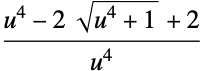

In [127]:
rMin2[u_] := (2 + u^4 - 2 Sqrt[1 + u^4])/u^4;
rMin2[u] // TraditionalForm

FormBox[RowBox[{FractionBox[RowBox[{"16", " ", SuperscriptBox["u", "6"]}], 

 
>         RowBox[{SubsuperscriptBox[OverscriptBox["r", "^"], "2", "4"], " ", 

 
>           SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], "2"], "′"]}]], "-", 

 
>        FractionBox[RowBox[{"40", " ", SuperscriptBox["u", "4"], " ", 

 
>           SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], "2"], "′"]}], 

 
>         SubsuperscriptBox[OverscriptBox["r", "^"], "2", "4"]], "-", 

 
>        FractionBox[RowBox[{"4", " ", SuperscriptBox["u", "2"], " ", 

 
>           SuperscriptBox[RowBox[{"(", 

 
>              SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], "2"], "′′"], ")"}], 

 
>            "2"]}], RowBox[{SubsuperscriptBox[OverscriptBox["r", "^"], "2", "2"], " ", 

 
>           SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], "2"], "′"]}]], "+", 

 
>        FractionBox[RowBox[{"24", " ", SuperscriptBox["u", "2"], " ", 

 
>           SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], "2"], "′"], " ", 

 
>           SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], "2"], "′′"]}], 

 
>         SubsuperscriptBox[OverscriptBox["r", "^"], "2", "3"]], "+", 

 
>        FractionBox[RowBox[{"4", " ", SuperscriptBox["u", "2"], " ", 

 
>           SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], "2"], "′′′′"]}], 

 
>         RowBox[{SubscriptBox[OverscriptBox["r", "^"], "2"], " ", 

 
>           SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], "2"], "′"]}]], "-", 

 
>        FractionBox[RowBox[{"11", " ", SuperscriptBox["u", "2"], " ", 

 
>           SuperscriptBox[RowBox[{"(", 

 
>              SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], "2"], "′"], ")"}], 

 
>            "3"]}], SubsuperscriptBox[OverscriptBox["r", "^"], "2", "4"]], "-", 

 
>        FractionBox[RowBox[{"12", " ", SuperscriptBox["u", "2"], " ", 

 
>           SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], "2"], "′′′"]}], 

 
>         SubsuperscriptBox[OverscriptBox["r", "^"], "2", "2"]], "+", 

 
>        FractionBox[SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], "2"],\
 
>    "′′′′′"], 
      "3"]}], TraditionalForm]
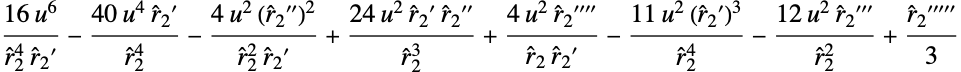

In [130]:
(* Минус учтём сразу *)
dEdr = Simplify[-dEdt/D[Subscript[OverHat[r], 2][OverHat[t]], OverHat[t]] //. OmegaReplace2];
Expand[Simplify[dEdr]] // TraditionalForm

<span style="color:brown">**NB:**</span> Выражение для $dE/dr$ <span style="color:green">**сопадает**</span> с выраженем для интегранта из binary_catch1.pdf, если учесть деление на $\hat{r}_2^{(1)}$

Из сохранения энергии следует, что
$\hat{E} = \hat{E}_\infty = \frac{u^2}{2} = \left(\frac{(\hat{r}^{(1)})^2}{2} + \frac{\hat{r}^2 \hat{\omega}^2}{2} - \frac{1}{\hat{r}}\right)$

Тогда можно найти $\hat{r}_2^{(1)}$:

FormBox[RowBox[{RowBox[{"-", "2"}], " ", 

 
>        SqrtBox[RowBox[{RowBox[{SubscriptBox[OverscriptBox["r", "^"], "2"], " ", 

 
>             SuperscriptBox["u", "2"]}], "+", 

 
>           RowBox[{"2", " ", SqrtBox[SubscriptBox[OverscriptBox["r", "^"], "2"]]}],\
 
>    "-", 
        SuperscriptBox["u", "2"]}]]}], TraditionalForm]
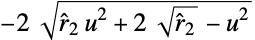

In [133]:
eq = Energy - u^2/2 //. Flatten[{
  ToR2Replacement,
  OmegaReplace2,
  D[Subscript[OverHat[r], 2][OverHat[t]], OverHat[t]]^2 -> x^2
}];

sol = Solve[eq == 0, x][[1]];

x /. sol[[1]] // TraditionalForm

А также $\hat{r}_2^{(i)}$ для $i = 1\dots5$

FormBox[RowBox[{"{", RowBox[{RowBox[{RowBox[{"-", "2"}], " ", 

 
>            SqrtBox[RowBox[{RowBox[{SubscriptBox[OverscriptBox["r", "^"], "2"], " ", 

 
>                 SuperscriptBox["u", "2"]}], "+", 

 
>               RowBox[{"2", " ", SqrtBox[SubscriptBox[OverscriptBox["r", "^"], "2"]]}],\
 
>    
            "-", SuperscriptBox["u", "2"]}]]}], ",", 

 
>          RowBox[{"2", " ", RowBox[{"(", 
           RowBox[{FractionBox["1", 

 
>                 SqrtBox[SubscriptBox[OverscriptBox["r", "^"], "2"]]], "+", 

 
>                SuperscriptBox["u", "2"]}], ")"}]}], ",", 

 
>          FractionBox[RowBox[{"2", " ", 

 
>             SqrtBox[RowBox[{RowBox[{SubscriptBox[OverscriptBox["r", "^"], "2"], " ", 

 
>                  SuperscriptBox["u", "2"]}], "+", 

 
>                RowBox[{"2", " ", SqrtBox[SubscriptBox[OverscriptBox["r", "^"], 

 
>                    "2"]]}], "-", SuperscriptBox["u", "2"]}]]}], 

 
>           SubsuperscriptBox[OverscriptBox["r", "^"], "2", RowBox[{"3", "/", "2"}]]], 

 
>          ",", FractionBox[RowBox[{"2", " ", 

 
>             RowBox[{"(", RowBox[{RowBox[{"2", " ", 

 
>                   SubscriptBox[OverscriptBox["r", "^"], "2"], " ", 

 
>                   SuperscriptBox["u", "2"]}], "+", 

 
>                 RowBox[{"5", " ", SqrtBox[SubscriptBox[OverscriptBox["r", "^"], 

 
>                     "2"]]}], "-", RowBox[{"3", " ", SuperscriptBox["u", "2"]}]}],\
 
>    ")"}\
]}], SubsuperscriptBox[OverscriptBox["r", "^"], "2", RowBox[{"5", "/",\
 
>    "2"}]]], ",", 
       FractionBox[RowBox[{"2", " ", 

 
>             SqrtBox[RowBox[{RowBox[{SubscriptBox[OverscriptBox["r", "^"], "2"], " ", 

 
>                  SuperscriptBox["u", "2"]}], "+", 

 
>                RowBox[{"2", " ", SqrtBox[SubscriptBox[OverscriptBox["r", "^"], 

 
>                    "2"]]}], "-", SuperscriptBox["u", "2"]}]], " ", 

 
>             RowBox[{"(", RowBox[{RowBox[{"6", " ", 

 
>                   SubscriptBox[OverscriptBox["r", "^"], "2"], " ", 

 
>                   SuperscriptBox["u", "2"]}], "+", 

 
>                 RowBox[{"20", " ", SqrtBox[SubscriptBox[OverscriptBox["r", "^"], 

 
>                     "2"]]}], "-", RowBox[{"15", " ", SuperscriptBox["u", "2"]}]}],\
 
>    ")"}\
]}], SubsuperscriptBox[OverscriptBox["r", "^"], "2", RowBox[{"7", "/",\
 
>    "2"}]]]}], "}"}]\
, TraditionalForm]
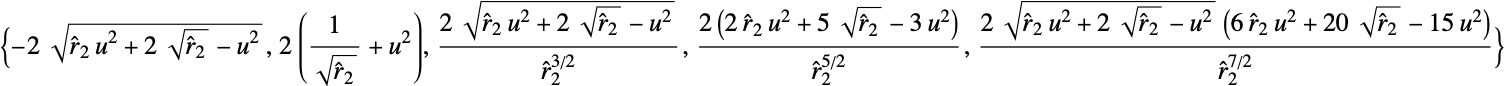

In [137]:
replacementRule = D[Subscript[OverHat[r], 2][OverHat[t]], OverHat[t]] :> x /. sol[[1]];

(* Рекурсивно вычисляем производные *)
dr2 = NestList[
   Simplify[D[#, OverHat[t]] /. replacementRule] &,
   x /. sol[[1]],
   4
];

dr2 // TraditionalForm

Заменяя вхождение **всех** производных в выражении для $dE/dr$, получим

FormBox[FractionBox[RowBox[{"2", " ", 
      RowBox[{"(", RowBox[{RowBox[{"6", " ", 

 
>               SubsuperscriptBox[OverscriptBox["r", "^"], "2", "2"], " ", 

 
>               SuperscriptBox["u", "4"]}], "+", 

 
>             RowBox[{SubscriptBox[OverscriptBox["r", "^"], "2"], " ", 

 
>               RowBox[{"(", RowBox[{RowBox[{"51", " ", SuperscriptBox["u", "4"]}], 

 
>                   "+", "40"}], ")"}]}], "+", 

 
>             RowBox[{"32", " ", SubsuperscriptBox[OverscriptBox["r", "^"], "2", 

 
>                RowBox[{"3", "/", "2"}]], " ", SuperscriptBox["u", "2"]}], "+", 

 
>             RowBox[{"100", " ", SqrtBox[SubscriptBox[OverscriptBox["r", "^"], "2"]], 

 
>               " ", SuperscriptBox["u", "2"]}], "-", 

 
>             RowBox[{"75", " ", SuperscriptBox["u", "4"]}]}], ")"}]}], 

 
>       RowBox[{"3", " ", SubsuperscriptBox[OverscriptBox["r", "^"], "2", 

 
>          RowBox[{"7", "/", "2"}]], " ", 

 
>         SqrtBox[RowBox[{RowBox[{SubscriptBox[OverscriptBox["r", "^"], "2"], " ", 

 
>              SuperscriptBox["u", "2"]}], "+", 

 
>            RowBox[{"2", " ", SqrtBox[SubscriptBox[OverscriptBox["r", "^"], "2"]]}],\
 
>    "-", 
         SuperscriptBox["u", "2"]}]]}]], TraditionalForm]
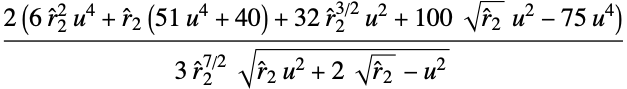

In [139]:
dEdrFinal = Fold[ (* Последовательно применяем замены *)
  Simplify[#1 /.
    D[Subscript[OverHat[r], 2][OverHat[t]], {OverHat[t], #2}] -> dr2[[#2]]] &,
  dEdr,
  Range[5]
];

Simplify[dEdrFinal] // TraditionalForm

$$
  \Delta \hat{E}(u) = \epsilon_G \frac{4}{3}\int\limits_{\hat{r}_2^\text{min}}^\infty \frac{32 \hat{r}_2^{3/2} u^2+6 \hat{r}_2^2 u^4+\hat{r}_2 \left(51 u^4+40\right)+100 \sqrt{\hat{r}_2} u^2-75 u^4}{\hat{r}_2^{7/2} \sqrt{\hat{r}_2 u^2+2 \sqrt{\hat{r}_2}-u^2}} \, d\hat{r}_2,
$$
где при $\hat{r}_2 \ge \hat{r}_2^{\text{min}}$ выражение $\hat{r}_2u^2 + 2\sqrt{\hat{r}_2} - u^2 \ge 0$.

Полученный выше интеграл **компактнее**, чем тот, что рассмотрен в файле binary_catch2.pdf
$$
  \Delta \hat{E}(u) = \epsilon_G \frac{4}{3}\int\limits_{\hat{r}_2^\text{min}}^\infty \frac{24\hat{r}_2^2u^6 + 48u^6\hat{r}_2 + 120\hat{r}_2^{3/2}u^4 - 96u^6 + 96u^4\sqrt{\hat{r}_2} - u^2\hat{r}_2^2 + 133u^2\hat{r}_2 - 2\hat{r}_2^{3/2}}{\hat{r}_2^4\sqrt{u^2\hat{r}_2 + 2\sqrt{\hat{r}_2} - u^2}} \, d\hat{r}_2,
$$

<span style="color:brown">**NB:**</span> Однако, будучи аналитически взятым будет полностью <span style="color:green">**совпадать!**</span>

Смотри подробности в файле binary_catch_integral.ipynb
 
Там компактный интеграл назван $I_5$, а второй $I_4$.

Выпишем ответ:

FormBox[RowBox[{"-", FractionBox[RowBox[{SubscriptBox["ϵ", "G"], " ", 

 
>           RowBox[{"(", RowBox[{RowBox[{RowBox[{"(", 

 
>                   RowBox[{RowBox[{"673", " ", SuperscriptBox["u", "4"]}], "+", 

 
>                     "1275"}], ")"}], " ", SuperscriptBox["u", "2"]}], "+", 

 
>               RowBox[{"3", " ", RowBox[{"(", 

 
>                   RowBox[{RowBox[{"37", " ", SuperscriptBox["u", "8"]}], "+", 

 
>                     RowBox[{"366", " ", SuperscriptBox["u", "4"]}], "+", "425"}],\
 
>    ")"}\
], " ", RowBox[{"(", RowBox[{RowBox[{SuperscriptBox["tan", RowBox[{"-",\
 
>    "1"}]], 
                    "(", FractionBox["1", SuperscriptBox["u", "2"]],\
 
>    ")"}], "+", 
                  FractionBox["π", "2"]}], ")"}]}]}], ")"}]}], 

 
>         RowBox[{"9", " ", SuperscriptBox["u", "7"]}]]}], TraditionalForm]
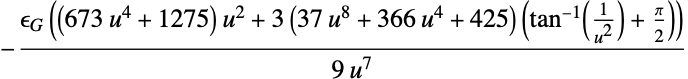

In [141]:
DeltaE = -Subscript[\[Epsilon], G]/9*(u^2*(1275 + 673*u^4) + 3*(425 + 366*u^4 + 37*u^8)*(Pi/2 + ArcTan[u^(-2)]))/u^7;
DeltaE // TraditionalForm

In [142]:
TeXForm[DeltaE]

-\frac{\epsilon _G \left(\left(673 u^4+1275\right) u^2+3 \left(37 u^8+366 u^4+425\right)\
 
>   \left(\tan ^{-1}\left(\frac{1}{u^2}\right)+\frac{\pi }{2}\right)\right)}{9 u^7}

<span style="color:red">**TODO_3:**</span> Обсудить почему при малых $u$ значения $\Delta \hat{E}(u)$ безгранично растут.

В задаче расчета средней потери энергии на грав изулчение предполагается близость к Ньютону.
При малых скоростях эта близость должна приводить к энергиям после одного оборота близким к нулю,
в противном случае мы сильно отклонимся от Ньютона,
получая несамосогласованные рассуждения.

FormBox[InterpretationBox[RowBox[{RowBox[{"-", 

 
>           FractionBox[RowBox[{"425", " ", 

 
>              RowBox[{"(", RowBox[{"π", " ", SubscriptBox["ϵ", "G"]}], ")"}]}], 

 
>            RowBox[{"3", " ", SuperscriptBox["u", "7"]}]]}], "+", 

 
>         InterpretationBox[RowBox[{"O", "(", 

 
>            FractionBox["1", SuperscriptBox["u", "3"]], ")"}], 

 
>          SeriesData[u, 0, List[], -7, -3, 1], Rule[Editable, False]]}], 

 
>       SeriesData[u, 0, List[Times[Rational[-425, 3], Pi, Subscript[\[Epsilon], G]]], 

 
>        -7, -3, 1], Rule[Editable, False]], TraditionalForm]
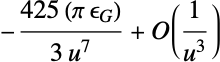

In [143]:
Simplify[Series[DeltaE, {u, 0, -4}]] // TraditionalForm

## Условия захвата

На бесконечнос энергия объекта была $u^2/2$

Если $2|\Delta \hat{E}| > u^2$, то гиперболическая орбита (или параболическая, если $u = 0$) превратится в эллиптическую за один полный оборот,

далее тело уже не сможет "уходить" на бесконечность.

Из-за ограничения локализации точнее условие захвата поставить **нельзя**

FormBox[RowBox[{SuperscriptBox["u", "9"], "<", 

 
>        RowBox[{FractionBox["2", "9"], " ", SubscriptBox["ϵ", "G"], " ", 

 
>          RowBox[{"(", RowBox[{RowBox[{RowBox[{"(", 

 
>                  RowBox[{RowBox[{"673", " ", SuperscriptBox["u", "4"]}], "+", 

 
>                    "1275"}], ")"}], " ", SuperscriptBox["u", "2"]}], "+", 

 
>              RowBox[{FractionBox["3", "2"], " ", 

 
>                RowBox[{"(", RowBox[{RowBox[{"37", " ", SuperscriptBox["u", "8"]}], 

 
>                    "+", RowBox[{"366", " ", SuperscriptBox["u", "4"]}], "+", "425"}], 

 
>                  ")"}], " ", RowBox[{"(", 
               RowBox[{RowBox[{"2", " ", 

 
>                      RowBox[{SuperscriptBox["tan", RowBox[{"-", "1"}]], "(", 

 
>                        FractionBox["1", SuperscriptBox["u", "2"]], ")"}]}], "+",\
 
>    "π"}], 
               ")"}]}]}], ")"}]}]}], TraditionalForm]
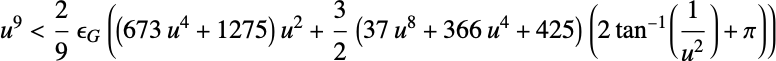

In [146]:
DeltaE2 = Simplify[DeltaE + u^2/2];
uMax2 = Simplify[2 u^7 DeltaE2];
Simplify[uMax2 < 0] // TraditionalForm

<span style="color:brown">**NB:**</span> Условие захвата, <span style="color:green">**совпадает**</span> с условием из файла binary_catch.pdf

<span style="color:red">**TODO_4:**</span> Сравнить условия захвата на параболической траектории $u = 0$ с другими авторами

FormBox[InterpretationBox[RowBox[{FractionBox[RowBox[{"850", " ", "π", " ", 

 
>            SubscriptBox["ϵ", "G"]}], "3"], "+", 

 
>         InterpretationBox[RowBox[{"O", "(", SuperscriptBox["u", "1"], ")"}], 

 
>          SeriesData[u, 0, List[], 0, 1, 1], Rule[Editable, False]]}], 

 
>       SeriesData[u, 0, List[Times[Rational[850, 3], Pi, Subscript[\[Epsilon], G]]], 0,\
 
>    
     1, 1], Rule[Editable, False]], TraditionalForm]
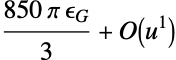

In [147]:
Simplify[Series[(u^9 - uMax2), {u, 0, 0}]] // TraditionalForm

## Поведение $\hat{E}_1$ в зависимости от начальной сокрости $u$ и параметра $\epsilon_G$

$$
\hat{E}_1 = \hat{E}_0 + \Delta \hat{E}
$$

$\epsilon_G = \frac{2}{5}\frac{\mu}{M} \left( \frac{r_s}{2b} \right)^{\frac{5}{2}}$,
где $r_s = \frac{2 G M}{c^2}$ - сумма радиусов Шварцшильда двух тел.

При прицельных параметрах $b$ сравнимых с радиусом Шварцшильда, $\epsilon_G$ не мал (смотри $\epsilon_G = 10$).

Энергия всегда отрицальна, тела уже в захвате.

Если прицельный параметр много больше, чем $r_s$, то есть $\epsilon_G$ мал,
то находится такая скорость, при значении которой (и меньших скоростях) происходит захват.

Legended[-Graphics-, Placed[LineLegend[{Directive[Opacity[1.], RGBColor[0.24, 0.6, 0.8], 
 
>       AbsoluteThickness[2]], Directive[Opacity[1.], RGBColor[0.95, 0.627, 0.1425], 
 
>       AbsoluteThickness[2]], Directive[Opacity[1.], RGBColor[0.455, 0.7, 0.21], 
 
>       AbsoluteThickness[2]], Directive[Opacity[1.], 
 
>       RGBColor[0.922526, 0.385626, 0.209179], AbsoluteThickness[2]], 
 
>      Directive[Opacity[1.], RGBColor[0.578, 0.51, 0.85], AbsoluteThickness[2]], 
 
>      Directive[Opacity[1.], RGBColor[0.772079, 0.431554, 0.102387], 
 
>       AbsoluteThickness[2]], Directive[Opacity[1.], RGBColor[0.4, 0.64, 1.], 
 
>       AbsoluteThickness[2]]}, {EpsilonG = 10, EpsilonG = 2, EpsilonG = 1, 
 
>      EpsilonG = 0.5, EpsilonG = 0.1, EpsilonG = 10^(-2), EpsilonG = 10^(-5)}, 
 
>     LegendMarkers -> None, LabelStyle -> {}, LegendLayout -> Column], After, Identity]]
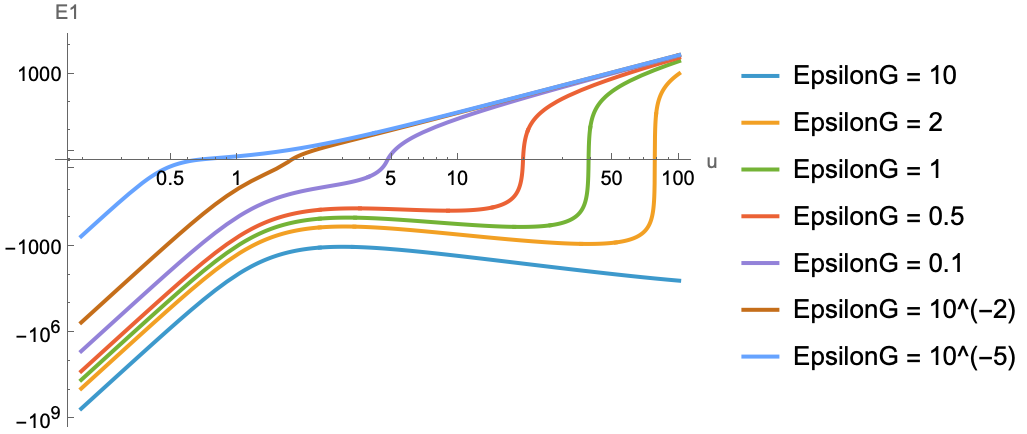

In [148]:
Plot[
  {
    u^2/2 + DeltaE /. Subscript[\[Epsilon], G] -> 10,
    u^2/2 + DeltaE /. Subscript[\[Epsilon], G] -> 2,
    u^2/2 + DeltaE /. Subscript[\[Epsilon], G] -> 1,
    u^2/2 + DeltaE /. Subscript[\[Epsilon], G] -> 0.5,
    u^2/2 + DeltaE /. Subscript[\[Epsilon], G] -> 0.1,
    u^2/2 + DeltaE /. Subscript[\[Epsilon], G] -> 10^(-2),
    u^2/2 + DeltaE /. Subscript[\[Epsilon], G] -> 10^(-5)
  },
  {u, 0.0, 100},
  AxesLabel -> {"u", "E1"},
  PlotLegends -> {
    "EpsilonG = 10",
    "EpsilonG = 2",
    "EpsilonG = 1",
    "EpsilonG = 0.5",
    "EpsilonG = 0.1",
    "EpsilonG = 10^(-2)",
    "EpsilonG = 10^(-5)"
    },
  PlotRange -> All,
  ScalingFunctions -> {"Log", "SignedLog"}
]

# Потеря момента за один период обращения

$$
\Delta \hat{J} = 2 \epsilon_G \int\limits_{\hat{t}_{\text{min}}}^{\infty}I_J(\hat{t}) d \hat{t}
= - 2 \epsilon_G \int\limits_{\hat{r}_2^{\text{min}}}^{\infty}\frac{I_J(\hat{r}_2)}{\hat{r}_2^{(1)}}d \hat{r}_2,
$$

где мы заменим $\hat{\omega}$ на $\frac{u}{\hat{r}_2}$

FormBox[RowBox[{FractionBox[RowBox[{"16", " ", SuperscriptBox["u", "5"]}], 

 
>         RowBox[{SubsuperscriptBox[OverscriptBox["r", "^"], "2", "3"], " ", 

 
>           SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], "2"], "′"]}]], "-", 

 
>        FractionBox[RowBox[{"20", " ", SuperscriptBox["u", "3"], " ", 

 
>           SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], "2"], "′"]}], 

 
>         SubsuperscriptBox[OverscriptBox["r", "^"], "2", "3"]], "-", 

 
>        FractionBox[RowBox[{"4", " ", "u", " ", 
        SuperscriptBox[RowBox[{"(", 

 
>              SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], "2"], "′′"], ")"}], 

 
>            "2"]}], RowBox[{SubscriptBox[OverscriptBox["r", "^"], "2"], " ", 

 
>           SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], "2"], "′"]}]], "+", 

 
>        FractionBox[RowBox[{"14", " ", "u", " ", 

 
>           SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], "2"], "′"], " ", 

 
>           SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], "2"], "′′"]}], 

 
>         SubsuperscriptBox[OverscriptBox["r", "^"], "2", "2"]], "+", 

 
>        FractionBox[RowBox[{"4", " ", "u", " ", 

 
>           SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], "2"], "′′′′"]}], 

 
>         SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], "2"], "′"]], "-", 

 
>        FractionBox[RowBox[{"6", " ", "u", " ", 
        SuperscriptBox[RowBox[{"(", 

 
>              SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], "2"], "′"], ")"}], 

 
>            "3"]}], SubsuperscriptBox[OverscriptBox["r", "^"], "2", "3"]], "-", 

 
>        FractionBox[RowBox[{"7", " ", "u", " ", 

 
>           SuperscriptBox[SubscriptBox[OverscriptBox["r", "^"], "2"], "′′′"]}], 

 
>         SubscriptBox[OverscriptBox["r", "^"], "2"]]}], TraditionalForm]
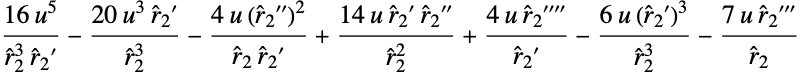

In [151]:
(* Минус учтём сразу *)
dJdr = Simplify[-dJdt/D[Subscript[OverHat[r], 2][OverHat[t]], OverHat[t]] //. OmegaReplace2];
Expand[Simplify[dJdr]] // TraditionalForm

<span style="color:brown">**NB:**</span> Выражение для $dJ/dr$ <span style="color:green">**сопадает**</span> с выраженем для интегранта из binary_catch3.pdf, если учесть деление на $\hat{r}_2^{(1)}$

Заменяя вхождение **всех** производных в выражении для $dJ/dr$, получим

FormBox[FractionBox[RowBox[{"2", " ", "u", " ", 

 
>         RowBox[{"(", RowBox[{RowBox[{"9", " ", 

 
>               SubscriptBox[OverscriptBox["r", "^"], "2"], " ", 

 
>               SuperscriptBox["u", "2"]}], "+", 

 
>             RowBox[{"20", " ", SqrtBox[SubscriptBox[OverscriptBox["r", "^"], "2"]]}], 

 
>             "-", RowBox[{"15", " ", SuperscriptBox["u", "2"]}]}], ")"}]}], 

 
>       RowBox[{SubsuperscriptBox[OverscriptBox["r", "^"], "2", RowBox[{"5", "/",\
 
>    "2"}]], 
      " ", SqrtBox[RowBox[{RowBox[{SubscriptBox[OverscriptBox["r", "^"],\
 
>    "2"], " ", 
           SuperscriptBox["u", "2"]}], "+", 

 
>            RowBox[{"2", " ", SqrtBox[SubscriptBox[OverscriptBox["r", "^"], "2"]]}],\
 
>    "-", 
         SuperscriptBox["u", "2"]}]]}]], TraditionalForm]
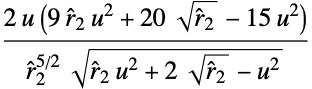

In [153]:
dJdrFinal = Fold[ (* Последовательно применяем замены *)
  Simplify[#1 /.
    D[Subscript[OverHat[r], 2][OverHat[t]], {OverHat[t], #2}] -> dr2[[#2]]] &,
  dJdr,
  Range[5]
];

Simplify[dJdrFinal] // TraditionalForm

$$
  \Delta \hat{J}(u) = 4 \epsilon_G \int\limits_{\hat{r}_2^\text{min}}^\infty \frac{u \left(20\sqrt{\hat{r}_2} - 15u^2 + 9\hat{r}_2 u^2\right)}{\hat{r}_2^{\frac{5}{2}} \sqrt{2\sqrt{\hat{r}_2} - u^2 + \hat{r}_2 u^2}} \, d\hat{r}_2,
$$
где при $\hat{r}_2 \ge \hat{r}_2^{\text{min}}$ выражение $\hat{r}_2u^2 + 2\sqrt{\hat{r}_2} - u^2 \ge 0$.

Полученный выше интеграл **компактнее**, чем тот, что рассмотрен в файле binary_catch3.pdf

Смотри подробности в файле binary_catch_integral.ipynb
 
Выпишем ответ:

FormBox[RowBox[{"4", " ", SubscriptBox["ϵ", "G"], " ", 

 
>        RowBox[{"(", RowBox[{RowBox[{"-", 

 
>              RowBox[{RowBox[{"2"}], " ", SuperscriptBox["u", "2"]}]}], "-", 

 
>            FractionBox["15", SuperscriptBox["u", "2"]], "-", 

 
>            FractionBox[RowBox[{RowBox[{"(", 

 
>                 RowBox[{RowBox[{"7", " ", SuperscriptBox["u", "4"]}], "+", "15"}], 

 
>                 ")"}], " ", RowBox[{"(", 
              RowBox[{RowBox[{"2", " ", 

 
>                     RowBox[{SuperscriptBox["tan", RowBox[{"-", "1"}]], "(", 

 
>                       FractionBox["1", SuperscriptBox["u", "2"]], ")"}]}], "+", "π"}],\
 
>    
              ")"}]}], RowBox[{"2", " ", SuperscriptBox["u", "4"]}]]}], ")"}]}], 

 
>      TraditionalForm]
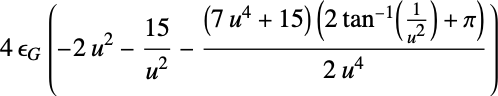

In [155]:
DeltaJ = 4*Subscript[\[Epsilon], G]*(-15/u^2 - 2*u^2 - ((15 + 7*u^4)*(Pi + 2*ArcTan[u^(-2)]))/(2*u^4));
DeltaJ // TraditionalForm

In [156]:
TeXForm[DeltaJ]

4 \epsilon _G \left(-2 u^2-\frac{15}{u^2}-\frac{\left(7 u^4+15\right) \left(2 \tan\
 
>   ^{-1}\left(\frac{1}{u^2}\right)+\pi \right)}{2 u^4}\right)

В пределе малых $u$ для $\Delta \hat{J}(u)$ получаем

<span style="color:red">**TODO_5:**</span> Обсудить почему при малых $u$ значения $\Delta \hat{J}(u)$ безгранично растут.

FormBox[RowBox[{"-", FractionBox[RowBox[{"60", " ", "π", " ", 

 
>           SubscriptBox["ϵ", "G"]}], SuperscriptBox["u", "4"]]}], TraditionalForm]
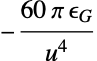

In [158]:
DeltaJSmallu = Normal[Simplify[Series[DeltaJ, {u, 0, -1}]]];
DeltaJSmallu // TraditionalForm

## Поведение $\hat{J}_1$ в зависимости от начальной сокрости $u$ и параметра $\epsilon_G$

$$
\hat{J}_1 = \hat{J}_0 + \Delta \hat{J}
$$

$\epsilon_G = \frac{2}{5}\frac{\mu}{M} \left( \frac{r_s}{2b} \right)^{\frac{5}{2}}$,
где $r_s = \frac{2 G M}{c^2}$ - сумма радиусов Шварцшильда двух тел.

При прицельных параметрах $b$ сравнимых с радиусом Шварцшильда, $\epsilon_G$ не мал (смотри $\epsilon_G = 0.1, 0.5, 1, 2, 10$),
момент полностью "съедается" на одном проходе вдоль гиперболической траектории.

Если прицельный параметр много больше, чем $r_s$, то есть $\epsilon_G$ мал ($\epsilon_G = 10^{-5}$),
то только на совсем малых скоростях может "съесться" момент.

<span style="color:red">**TODO_6:**</span> Нет отрицательного момнета!

Legended[-Graphics-, Placed[LineLegend[{Directive[Opacity[1.], RGBColor[0.24, 0.6, 0.8], 
 
>       AbsoluteThickness[2]], Directive[Opacity[1.], RGBColor[0.95, 0.627, 0.1425], 
 
>       AbsoluteThickness[2]], Directive[Opacity[1.], RGBColor[0.455, 0.7, 0.21], 
 
>       AbsoluteThickness[2]], Directive[Opacity[1.], 
 
>       RGBColor[0.922526, 0.385626, 0.209179], AbsoluteThickness[2]], 
 
>      Directive[Opacity[1.], RGBColor[0.578, 0.51, 0.85], AbsoluteThickness[2]], 
 
>      Directive[Opacity[1.], RGBColor[0.772079, 0.431554, 0.102387], 
 
>       AbsoluteThickness[2]], Directive[Opacity[1.], RGBColor[0.4, 0.64, 1.], 
 
>       AbsoluteThickness[2]]}, {EpsilonG = 10, EpsilonG = 2, EpsilonG = 1, 
 
>      EpsilonG = 0.5, EpsilonG = 0.1, EpsilonG = 10^(-2), EpsilonG = 10^(-5)}, 
 
>     LegendMarkers -> None, LabelStyle -> {}, LegendLayout -> Column], After, Identity]]
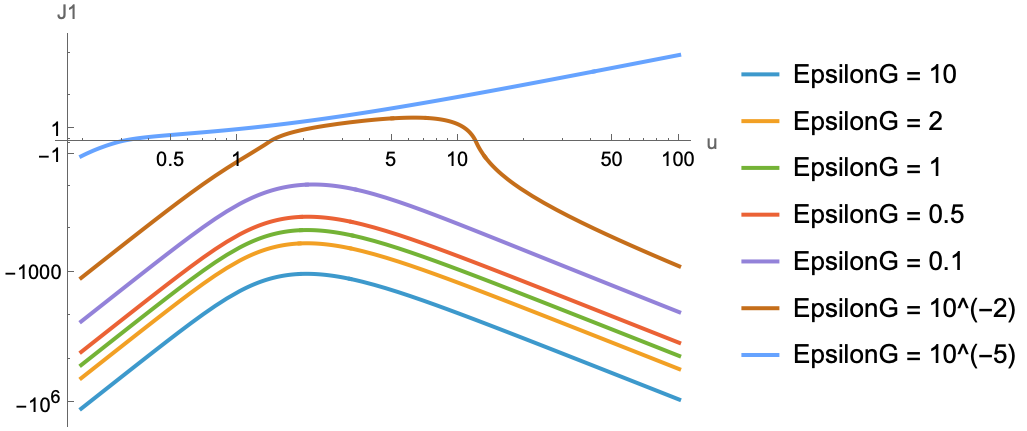

In [159]:
Plot[
  {
    u + DeltaJ /. Subscript[\[Epsilon], G] -> 10,
    u + DeltaJ /. Subscript[\[Epsilon], G] -> 2,
    u + DeltaJ /. Subscript[\[Epsilon], G] -> 1,
    u + DeltaJ /. Subscript[\[Epsilon], G] -> 0.5,
    u + DeltaJ /. Subscript[\[Epsilon], G] -> 0.1,
    u + DeltaJ /. Subscript[\[Epsilon], G] -> 10^(-2),
    u + DeltaJ /. Subscript[\[Epsilon], G] -> 10^(-5)
  },
  {u, 0.0, 100},
  AxesLabel -> {"u", "J1"},
  PlotLegends -> {
    "EpsilonG = 10",
    "EpsilonG = 2",
    "EpsilonG = 1",
    "EpsilonG = 0.5",
    "EpsilonG = 0.1",
    "EpsilonG = 10^(-2)",
    "EpsilonG = 10^(-5)"
    },
  PlotRange -> All,
  ScalingFunctions -> {"Log", "SignedLog"}
]

<span style="color:red">**TODO_7:**</span> Где быстрее набирается интеграл потерь момента импульса?

Смотри файл binary_catch_integral.ipynb (График первообразной $\tilde{I}_7(u_i, r)$)

# Время слияния

Пусть у нас есть 
$$
\begin{align}
\hat{E}_1 &= \hat{E}_0 + \Delta \hat{E}
\\
\hat{J}_1 &= \hat{J}_0 + \Delta \hat{J}
\end{align}
$$
нужно получить время слияния $\tau$ и параметры орбиты.

$a = b/\sqrt{1-e^2}$,

$J = \mu\sqrt{GMa(1-e^2)} = \mu\sqrt{GMb}\sqrt{\frac{b}{a}}$

Момент системы после одного полного оборота вдоль ньютоновской гиперболической орбиты с учетом излучения гравволн
$$
  \hat{J}_1 = \hat{J}_0 + \Delta \hat{J} = u - 4 \epsilon_G \left(2 u^2+\frac{15}{u^2}+\frac{\left(7 u^4+15\right) \left(2 \tan ^{-1}\left(\frac{1}{u^2}\right)+\pi \right)}{2 u^4}\right) \approx \sqrt{\frac{b}{a}} = \hat{a}^{-1/2}
$$

Отсюда характерная длина большой полуоси эллиптической орбиты в случае выполнения условия захвата после одного полного оборота будет
$$
a \approx b\hat{J}_1^{-2}
$$

А время, за которое расстояние между объектов уменьшится до нуля будет
$$
\tau \approx \frac{5}{8}\frac{c^5}{G^3}\frac{b^4}{\mu M^2} \frac{1}{\hat{J}_1^8}
$$

<span style="color:red">**TODO_8:**</span> Переделать расчет $\tau$

In [160]:
(*J1Smallu = - 60 Pi eG / u^4;
eG = 2/5*\[Mu]/M*(G M / (b c^2))^(5/2);
u = v/Sqrt[(G*M)/b];
N[5/8*c^5/G^3*b^4/(\[Mu]*M^2*J1Smallu)^(8)]*)